# **Capstone Project: NYC Taxi Fare Prediction** 🚕

Il presente progetto si basa sull’analisi di un campione rappresentativo del dataset pubblico tlc_yellow_trips_2022, che raccoglie informazioni sulle corse dei taxi gialli nella città di New York durante l’anno 2022. L’obiettivo generale è duplice:

Esplorare e comprendere il comportamento delle corse attraverso statistiche descrittive, visualizzazioni, e analisi temporali e spaziali.

Sviluppare un modello predittivo in grado di stimare il costo (fare_amount) di una corsa in funzione delle caratteristiche del viaggio (distanza, durata, orario, località ecc.).



---



## **1. Caricamento del dataset da BigQuery**




In [ ]:
# Autenticazione per accedere ai dati su BigQuery

from google.colab import auth  # Il modulo auth serve per autentificarsi su Google
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='bigquery-public-data-454010')   #crea un oggetto client che permette di eseguire query SQL su BigQuery.



---



###🔍 1.1 Query SQL: Campionamento mensile stratificato
La seguente query esegue un campionamento casuale stratificato per mese della tabella tlc_yellow_trips_2022.


In primis, seleziona le corse con pickup_datetime non nullo ed estrae variabili chiave:
*  🕓 `pickup_datetime`: la data e l'ora della salita sul taxi
*  🕘 `dropoff_datetime`: la data e l'ora del termine della corsa
*  👥 `passenger_count`: il numero di passeggeri della corsa
*  🗺️ `trip_distance`: i km percorsi dal taxi
*  💰 `fare_amount`: il costo della corsa in dollari
*  🪙 `tip_amount`: l'ammontare della mancia in dollari
*  📍 `pickup_location_id`: l'id del luogo dove è iniziata la corsa
*  📍 `dropoff_location_id`: l'id del luogo dove è finita la corsa

Successivamente crea l'attributo `month`, estraendolo dalla data di pickup.

Aggiunge poi una colonna `random_value` con un numero casuale per ogni riga e aggruppa i dati per mese, assegnando un numero progressivo ordinato per random_value.

Tiene solo le prime 8.400 corse per ciascun mese, in modo da ottenere un  campione bilanciato lungo l’anno.

Il risultato finale dovrebbe restituire circa 100.800 righe totali (8.400 x 12 mesi), garantendo rappresentatività temporale e riducendo i tempi di elaborazione.

In [ ]:
query = """
WITH monthly_sample AS (
  SELECT * FROM (
    SELECT
      pickup_datetime,
      dropoff_datetime,
      passenger_count,
      trip_distance,
      fare_amount,
      tip_amount,
      pickup_location_id,
      dropoff_location_id,
      EXTRACT(MONTH FROM pickup_datetime) AS month,
      RAND() AS random_value
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2022`
    WHERE pickup_datetime IS NOT NULL
  )
  QUALIFY ROW_NUMBER() OVER (PARTITION BY month ORDER BY random_value) <= 8400
)
SELECT *
FROM monthly_sample
"""

# Eseguiamo la query e salviamo i dati in un DataFrame Pandas
df = client.query(query).to_dataframe()



---



###📊 1.2 Verifica del campionamento mensile
Dopo aver eseguito la query SQL, vogliamo assicurarci che il campione contenga lo stesso numero di corse per ciascun mese.

In [ ]:
import pandas as pd

# per sicurezza contiamo il numero di corse per ogni mese
monthly_counts = df.groupby('month').size().reset_index(name='num_trips')

# ordiniamo i mesi in ordine crescente
monthly_counts = monthly_counts.sort_values('month')

print(monthly_counts)

    month  num_trips
0       1       8400
1       2       8400
2       3       8400
3       4       8400
4       5       8400
5       6       8400
6       7       8400
7       8       8400
8       9       8400
9      10       8400
10     11       8400
11     12        117


L’analisi stagionale è stata eseguita su base mensile, con un campione bilanciato per ciascun mese. Tuttavia, il mese di dicembre è stato sottorappresentato nel dataset disponibile (137 righe) e pertanto le inferenze su questo mese devono essere interpretate con cautela.

In [ ]:
# otteniamo la grandezza del sample
df.shape

(92517, 10)

Il sample ottenuto dal dataset è di poco più di novantamila record, per 10 attributi



---



## **2. Esplorazione dei dati e statistiche descrittive**

### 🧹 2.1 Pulizia del sample
Notiamo subito che gli attributi `trip_distance`, `fare_amount` e `tip_amount`
sono difficilmente interpretabili, quindi li convertiamo in float

In [ ]:
# conversione
df['trip_distance']=df['trip_distance'].astype(float)
df['fare_amount']=df['fare_amount'].astype(float)
df['tip_amount']=df['tip_amount'].astype(float)





Controlliamo se ci sono valori nulli

In [ ]:
# somma di valori nulli
df.isnull().sum()

,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,3220
trip_distance,0
fare_amount,0
tip_amount,0
pickup_location_id,0
dropoff_location_id,0
month,0
random_value,0


Notiamo che l'attributo `passenger_count` conta circa 3000 valori nulli. Procediamo con l'esplorazione di questi record:

In [ ]:
# controlliamo le righe con i valori nulli
df.loc[df['passenger_count'].isnull()]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,pickup_location_id,dropoff_location_id,month,random_value
8,2022-02-17 09:54:00+00:00,2022-02-17 10:12:00+00:00,<NA>,10.94,36.33,8.20,33,138,2,0.000022
34,2022-02-16 04:02:12+00:00,2022-02-16 04:02:44+00:00,<NA>,1.83,15.20,0.00,265,205,2,0.000126
43,2022-02-02 08:39:00+00:00,2022-02-02 08:58:00+00:00,<NA>,2.64,14.20,3.77,4,170,2,0.000165
55,2022-02-18 14:02:12+00:00,2022-02-18 15:02:48+00:00,<NA>,2.95,35.20,0.00,265,42,2,0.000267
57,2022-02-19 16:16:00+00:00,2022-02-19 16:25:00+00:00,<NA>,1.52,9.28,1.00,61,17,2,0.000279
...,...,...,...,...,...,...,...,...,...,...
92176,2022-04-10 14:51:39+00:00,2022-04-10 15:10:14+00:00,<NA>,2.70,13.50,2.52,90,229,4,0.001115
92250,2022-04-11 11:09:45+00:00,2022-04-11 11:37:47+00:00,<NA>,3.55,22.45,5.61,90,141,4,0.002309
92277,2022-11-20 02:26:50+00:00,2022-11-20 02:38:11+00:00,<NA>,3.24,21.65,0.00,90,261,11,0.000350
92377,2022-03-01 10:40:51+00:00,2022-03-01 10:56:13+00:00,<NA>,1.70,10.50,2.07,90,162,3,0.000172


Possiamo notare che, nonostante i valori nulli, gli altri attibuti riportano dati diversi da 0. Siamo di fronte a due scelte: riempire i valori nulli ed utilizzarli, o rimuoverli completamente.
Decidiamo di rimuovere solamente le righe che, oltre ai valori nulli di `passenger_count` hanno anche un valore uguale a 0 nell'attributo `trip_distance`

In [ ]:
# creiamo il dataset delete1, composto dalle righe in cui si riscontrano sia valori nulli di passenger_count che distanza percorsa pari zero
delete1 = df[(df['passenger_count'].isna()) & (df['trip_distance']==0)]
df = df.drop(delete1.index)

In [ ]:
# ricontrolliamo i valori nulli
df.isnull().sum()

,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,3046
trip_distance,0
fare_amount,0
tip_amount,0
pickup_location_id,0
dropoff_location_id,0
month,0
random_value,0


Abbiamo rimosso all'incirca 100 righe. Ora procediamo con sostituire ai valori nulli un valore effettivo: in questo caso, trattandosi di una variabile numerica discreta, abbiamo deciso di inserire la moda, ovvero il valore con più frequenza

In [ ]:
# calcolo moda
df['passenger_count'].mode()


,passenger_count
0,1


La maggior parte dei taxi di NY trasporta un solo passeggero

In [ ]:
# procediamo a sostituire i valori nulli con la moda
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mode()[0])

# controlliamo se la modifica è andata a buon fine
df.isnull().sum()

,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
trip_distance,0
fare_amount,0
tip_amount,0
pickup_location_id,0
dropoff_location_id,0
month,0
random_value,0


Procediamo con la ricerca di eventuali valori negativi nelle colonne `fare_amount`, `trip_distance` e `tip_amount`

In [ ]:
# cerchiamo valori negativi nelle tre colonne
df[(df['fare_amount']<0)|(df['trip_distance']<0)|(df['tip_amount']<0)]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,pickup_location_id,dropoff_location_id,month,random_value
56,2022-02-04 22:59:36+00:00,2022-02-04 23:00:29+00:00,1,0.01,-2.5,0.0,74,74,2,0.000274
98,2022-02-28 12:08:10+00:00,2022-02-28 12:08:58+00:00,1,0.00,-2.5,0.0,226,264,2,0.000460
106,2022-02-22 20:35:40+00:00,2022-02-22 20:36:48+00:00,1,0.75,-79.0,0.0,265,265,2,0.000510
169,2022-02-25 16:04:02+00:00,2022-02-25 16:04:41+00:00,1,0.09,-2.5,0.0,74,74,2,0.000887
281,2022-02-07 10:20:11+00:00,2022-02-07 10:20:19+00:00,1,0.00,-80.0,0.0,1,1,2,0.001690
...,...,...,...,...,...,...,...,...,...,...
91879,2022-09-13 14:44:40+00:00,2022-09-13 14:45:01+00:00,1,0.01,-2.5,0.0,90,90,9,0.001210
91970,2022-07-01 16:46:55+00:00,2022-07-01 16:47:01+00:00,1,0.00,-2.5,0.0,90,90,7,0.000150
92149,2022-04-09 11:57:11+00:00,2022-04-09 11:58:31+00:00,1,0.17,-3.0,0.0,90,249,4,0.000702
92426,2022-03-01 23:26:34+00:00,2022-03-01 23:31:58+00:00,1,1.38,-6.0,0.0,90,164,3,0.001014


trattandosi solamente di circa 600 record, procediamo con la rimozione. Come prima creiamo un nuovo dataframe e lo 'sottraiamo' a quello principale

In [ ]:
# creiamo il dataframe delete2 con le tre colonne e lo rimuoviamo
delete2 = df[(df['fare_amount']<0)|(df['trip_distance']<0)|(df['tip_amount']<0)]
df = df.drop(delete2.index)

Inoltre, controlliamo se ci sono righe in cui la `pickup_datetime` risulta avvenire dopo la `dropoff_datetime`

In [ ]:
#controllo
df[df['dropoff_datetime'] < df['pickup_datetime']]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,pickup_location_id,dropoff_location_id,month,random_value
192,2022-02-10 17:02:48+00:00,2022-02-10 17:02:26+00:00,1,2.59,35.20,0.00,265,173,2,0.001009
203,2022-02-14 23:02:39+00:00,2022-02-14 23:02:18+00:00,1,2.54,15.20,0.00,265,151,2,0.001101
262,2022-02-17 22:02:54+00:00,2022-02-17 22:02:50+00:00,1,10.36,42.20,0.00,265,85,2,0.001524
308,2022-02-09 16:02:32+00:00,2022-02-09 16:02:11+00:00,1,5.52,19.69,0.00,265,223,2,0.001828
405,2022-02-06 16:02:49+00:00,2022-02-06 16:02:03+00:00,1,12.17,33.27,0.00,265,131,2,0.002411
475,2022-10-29 07:10:05+00:00,2022-10-29 07:10:00+00:00,1,5.65,33.47,0.00,265,181,10,0.000091
704,2022-10-22 12:10:59+00:00,2022-10-22 12:10:10+00:00,1,5.06,30.84,0.00,265,50,10,0.001297
716,2022-10-30 19:10:35+00:00,2022-10-30 19:10:03+00:00,1,0.96,35.20,0.00,265,173,10,0.001335
1004,2022-05-18 06:05:21+00:00,2022-05-18 06:05:13+00:00,1,11.02,34.65,0.00,265,209,5,0.000416
1031,2022-05-16 17:05:04+00:00,2022-05-16 17:05:01+00:00,1,5.86,39.50,0.00,265,225,5,0.000543


anche qua, trattandosi di poco più di trenta righe, procediamo con la rimozione

In [ ]:
# rimozione
delete3 = df[df['dropoff_datetime'] < df['pickup_datetime']]
df = df.drop(delete3.index)

In [ ]:
# controlliamo la dimensione
df.shape

(91702, 10)

Si conclude la parte preliminare di pulizia



---



###🧭 2.2 Exploratory data analysis
Analizziamo gli indici di statistica univariata e rappresentiamo i risultati sui grafici

In [ ]:
# calcolo statistiche
df.describe()

,passenger_count,trip_distance,fare_amount,tip_amount,month,random_value
count,91702.0,91702.000000,91702.000000,91702.000000,91702.0,9.170200e+04
mean,1.385346,8.851857,14.742942,2.742877,6.002366,1.937558e-03
std,0.954763,1005.102822,13.855555,3.232813,3.166579,2.107471e-02
min,0.0,0.000000,0.000000,0.000000,1.0,4.534171e-08
25%,1.0,1.120000,7.000000,1.000000,3.0,6.333705e-04
50%,1.0,1.900000,10.000000,2.160000,6.0,1.271326e-03
75%,1.0,3.560000,16.000000,3.360000,9.0,1.909685e-03
max,7.0,275692.340000,460.000000,150.000000,12.0,9.931453e-01


*  👥 `passenger_count`: dai dati possiamo vedere che in media su ogni taxi salgono una o due persone al massimo. possiamo notare che il numero massimo di persone salite su un taxi è di 6. Sicuramente si tratta di uno di quei furgoncini che trasporta più di 4 persone. Solitamente però, la mediana è 1, e la ds è di 0.95. Viene da pensare che i taxi siano presi per lo più da 1 persona.

*  🗺️ `trip_distance`: in questo attributo possiamo notare la presenza di valori estremi, come si può vedere dalla differenza tra il 75esimo percntile ed il valore massimo. La distribuzione sembra avere una standard deviation abbastanza alta.

*  💰 `fare_amount`: anche per quanto riguarda l'attributo della spesa si possono notare le stesse cose. Non è strano però, in quanto può capitare che alcune tra le corse effettuate siano estremamente lunghe e, di conseguenza, estremamente costose.

*  🪙 `tip_amount`: l'ammontare della mancia è tra le variabili analizzate, quella che forse si avvicina di più ad una distribuzione normale, in quanto media e mediana sono piuttosto simili, ed il primo ed il terzo quartile sono equamente distribuiti.

In [ ]:
# importiamo le librerie necessarie per la data visualization
import seaborn as sns
import matplotlib.pyplot as plt

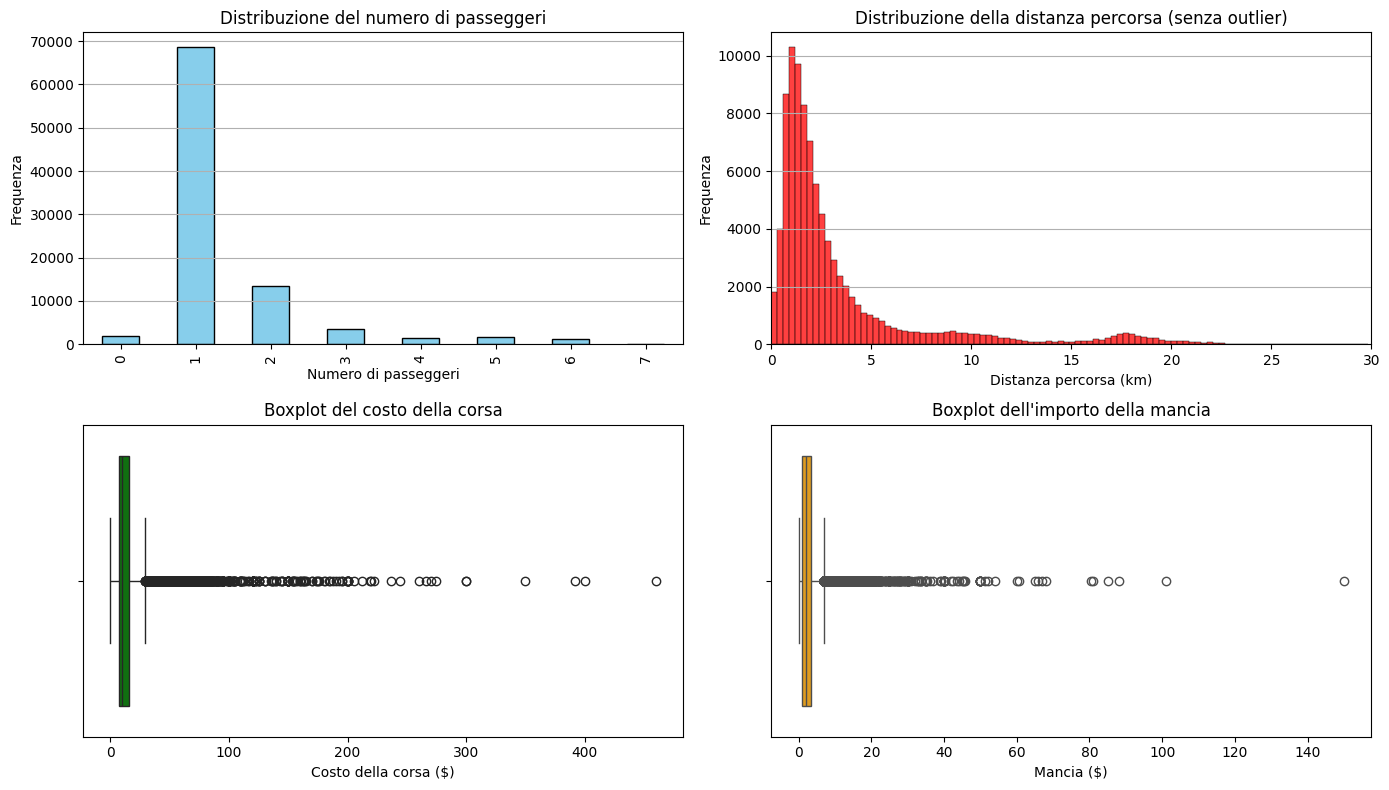

In [ ]:
# creiamo la griglia 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1️⃣ Barplot di passenger_count
df['passenger_count'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')

axes[0, 0].set_title("Distribuzione del numero di passeggeri")
axes[0, 0].set_xlabel("Numero di passeggeri")
axes[0, 0].set_ylabel("Frequenza")
axes[0, 0].grid(axis='y')

# 2️⃣ Histplot di trip_distance senza outlier
filtered_df = df[df['trip_distance'] <= 30]   #evitiamo gli outliers

sns.histplot(filtered_df['trip_distance'], ax=axes[0, 1], color='red', bins=100)
axes[0, 1].set_xlim(0, 30)
axes[0, 1].set_title("Distribuzione della distanza percorsa (senza outlier)")
axes[0, 1].set_xlabel("Distanza percorsa (km)")
axes[0, 1].set_ylabel("Frequenza")
axes[0, 1].grid(axis='y')


# 3️⃣ Boxplot di fare_amount
sns.boxplot(x=df['fare_amount'], ax=axes[1, 0], color='green')
axes[1, 0].set_title("Boxplot del costo della corsa")
axes[1, 0].set_xlabel("Costo della corsa ($)")

# 4️⃣ Boxplot di tip_amount
sns.boxplot(x=df['tip_amount'], ax=axes[1, 1], color='orange')
axes[1, 1].set_title("Boxplot dell'importo della mancia")
axes[1, 1].set_xlabel("Mancia ($)")

# Ottimizza il layout
plt.tight_layout()
plt.show()

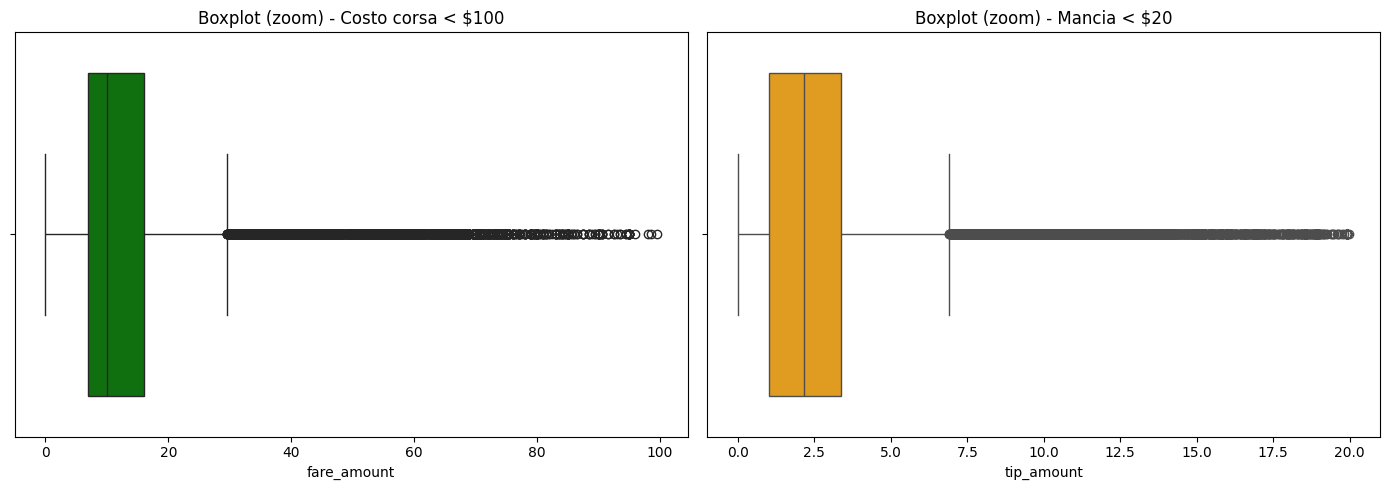

In [ ]:
# zoom sui due boxplot, in modo da avere un'immagine più chiara dei valori senza troppi outlier

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x=df[df['fare_amount'] < 100]['fare_amount'], ax=axes[0], color='green')
axes[0].set_title("Boxplot (zoom) - Costo corsa < $100")

sns.boxplot(x=df[df['tip_amount'] < 20]['tip_amount'], ax=axes[1], color='orange')
axes[1].set_title("Boxplot (zoom) - Mancia < $20")

plt.tight_layout()
plt.show()

Dall’analisi del numero di passeggeri non emergono informazioni nuove rispetto a quanto già osservato: la moda è pari a 1, confermando che la maggior parte delle corse riguarda singoli passeggeri.
La presenza di corse con 0 passeggeri potrebbe indicare errori di registrazione, test tecnici del sistema o corse annullate. Potrebbe essere opportuno escluderle da alcune analisi, a seconda del contesto.

Per quanto riguarda la distribuzione della distanza percorsa, si osserva che la maggior parte dei taxi copre tragitti inferiori ai 5 chilometri. La distribuzione risulta fortemente asimmetrica a destra, con una lunga coda verso valori elevati.
Inoltre, il picco secondario intorno ai 15 km potrebbe corrispondere a tragitti verso aeroporti o zone periferiche — vale la pena investigarlo.

Infine, i boxplot relativi al costo della corsa e all’importo della mancia mostrano una presenza significativa di outlier. In particolare, si nota che il 75% delle corse ha un costo inferiore a 20 dollari, mentre il 75% delle mance è inferiore a 5 dollari.
La mediana di fare_amount si trova attorno ai 10 dollari, confermando che la maggior parte delle corse rientra in un budget relativamente contenuto.
Gli outlier superiori-oltre i 100 dollari- potrebbero rappresentare corse interurbane, errate, o corse verso destinazioni molto lontane come JFK o Newark.

La mancia media sembra concentrarsi tra 0 e 5 dollari, suggerendo che le mance sono modeste ma frequenti. Gli outlier oltre i 50 dollari potrebbero riflettere casi eccezionali, clienti generosi o errori di input.
Potrebbe essere interessante confrontare la mancia rispetto alla modalità di pagamento o al giorno della settimana.



---



### 🔍 2.3 Durata, distanza e tariffa media dei viaggi

Iniziamo con il creare un nuovo attributo, che chiameremo `time_duration`, contenente la durata del viaggio in minuti. La otteniamo sottraendo `pickup_datetime` a `dropoff_datetime`

In [ ]:
# creazione della colonna time_duration
df['time_duration'] = df['dropoff_datetime']- df['pickup_datetime']
df['time_duration'] = df['time_duration'].dt.total_seconds()/60

Calcoliamo ora le tre medie richieste

In [ ]:
distanza_media = df['trip_distance'].mean()  #in miglia
durata_media = df['time_duration'].mean()  #in minuti
tariffa_media = df['fare_amount'].mean()  #in dollari

print(distanza_media, durata_media, tariffa_media)

8.851857429499901 17.285292032889142 14.742942247715426


la distanza media è uguale a circa 10km percorsi.

la durata media di ogni viaggio è pari a circa 18 minuti

la tariffa media è pari a circa 14 dollari.

Le tre medie hanno i valori che ci aspettavamo.

### 📍 2.1 Punti di partenza e arrivo più popolari

In [ ]:
from IPython.display import display, HTML

pickup = df['pickup_location_id'].value_counts().head(10)
dropoff = df['dropoff_location_id'].value_counts().head(10)

# Converto le due Series in DataFrame (così hanno intestazioni)
pickup_df = pickup.to_frame(name='n_pickup')
dropoff_df = dropoff.to_frame(name='n_dropoff')

# Converto entrambi i DataFrame in HTML e li metto fianco a fianco tramite flexbox, che permette una gestione flessibile degli elementi in un contenitore
html = f"""
<div style="display: flex; justify-content: space-around;">
  <div>{pickup_df.to_html()}</div>
  <div>{dropoff_df.to_html()}</div>
</div>
"""

display(HTML(html))

,n_pickup
pickup_location_id,
132,4422
237,4307
236,3803
161,3570
142,3129
186,2925
162,2905
230,2879
170,2795


dalle tabelle ottenute si evince una dato curioso: la posizione 132 è la prima nella classifica delle posizioni dove le corse partono, ma non figura nella top 10 delle posizioni dove le corse finiscono, a differenza di quasi tutti gli altri valori. Sarbbe interessare individuare quella posizione ed indagare in maniera più approfondita.

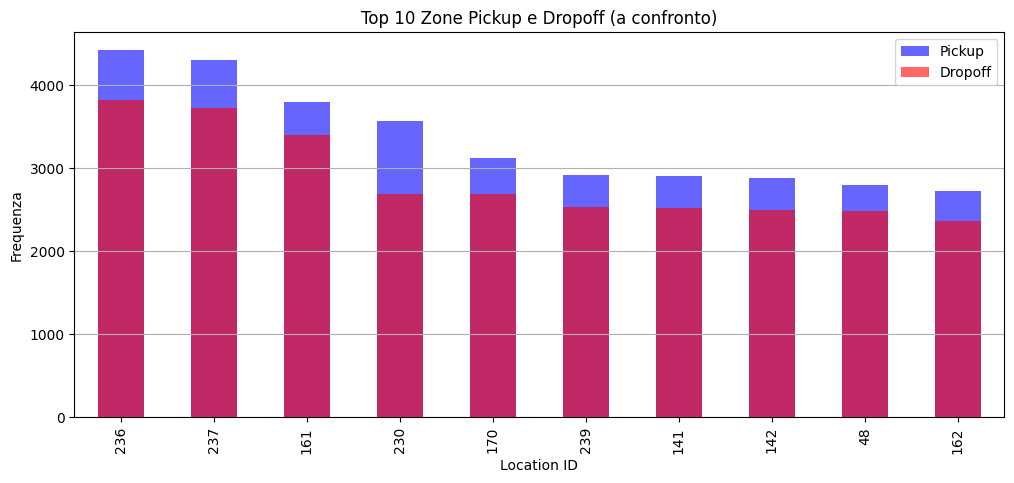

In [ ]:
#rappresentiamo tramite un barplot il confronto tra le 10 posizioni dove le corse iniziano e dove terminano

pickup.head(10).plot(kind='bar', color='blue', alpha=0.6, label='Pickup', figsize=(12, 5))
dropoff.head(10).plot(kind='bar', color='red', alpha=0.6, label='Dropoff')

plt.title("Top 10 Zone Pickup e Dropoff (a confronto)")
plt.xlabel("Location ID")
plt.ylabel("Frequenza")
plt.legend()
plt.grid(axis='y')
plt.show()

Dal grafico si evince che tra le dieci posizioni più popolari, le corse iniziano più di quanto terminino. Questo fenomeno può ricondursi al fatto che siano punti d'interesse dove le persone salgono sul taxi.



---



### ⏰ 2.4 Orari di punta

Vogliamo analizzare ora quali sono le ore di punta in cui vengono presi più taxi durante la giornata

In [ ]:
# creiamo una nuova colonna, ottenendo l'ora dall'attributo pickup_datetime
df['trip_hour']=df['pickup_datetime'].dt.hour
df.groupby('trip_hour').size().sort_values(ascending=False).head(10)

,0
trip_hour,
18,6513
17,6346
19,5760
15,5753
16,5657
14,5613
13,5135
12,5054
20,5051


Notiamo che l'ora di punta è alle 18, quando la gente esce da lavoro, seguita dalle 17 e dalle 19. Rappresentiamo questi dati su un istogramma.

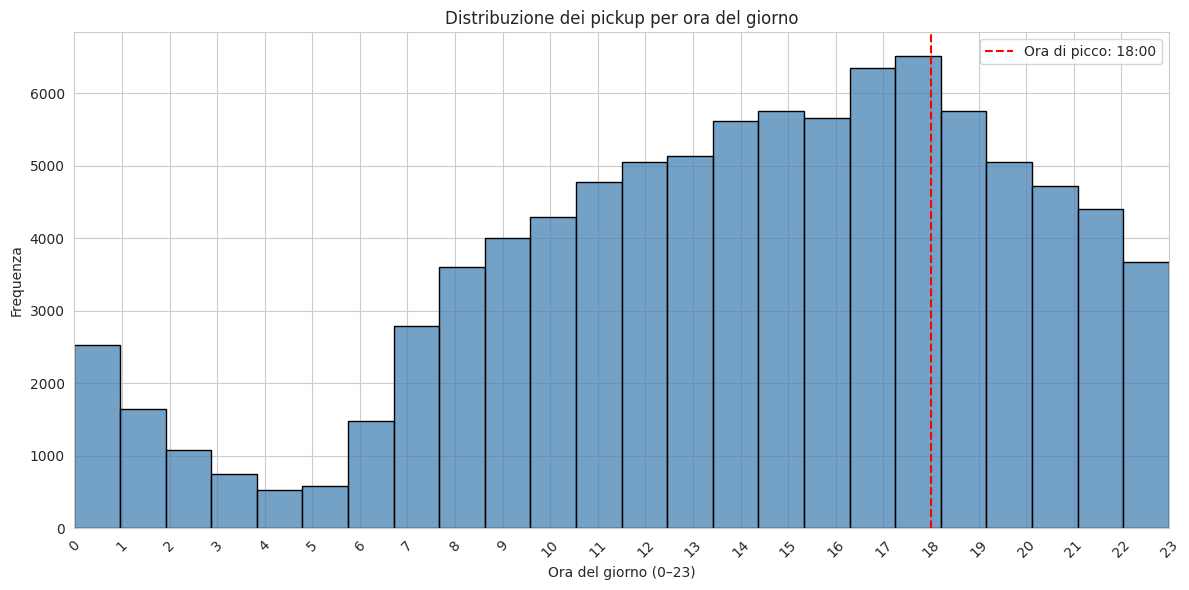

In [ ]:
sns.set_style("whitegrid")  # sfondo con griglia leggera

plt.figure(figsize=(12, 6))
sns.histplot(x='trip_hour', data=df, bins=24, color='steelblue', edgecolor='black')

# aggiunta linea verticale sull'ora di picco
peak_hour = df['trip_hour'].value_counts().idxmax()
plt.axvline(peak_hour, color='red', linestyle='--', label=f'Ora di picco: {peak_hour}:00')
plt.legend()

# etichette e limiti
plt.xticks(range(24), rotation=45)
plt.xlim(0, 23)
plt.title('Distribuzione dei pickup per ora del giorno')
plt.xlabel('Ora del giorno (0–23)')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()


Dal grafico possiamo confermare l'analisi effettuata sui dati, ovvero che le ore in cui vengono effettuate più corse è intorno alle 18.
Si può notare però che ne vengono effettuate parecchie anche nelle ore serali. Il minimo avviene intorno alle 5 del mattino.



---



### 📈 2.5 Analisi di stagionalità e stazionarietà

Innanzitutto definiamo cosa si intende con questi due concetti:

L'analisi di stagionalità ha l’obiettivo di osservare se la distribuzione dei dati segue un andamento ciclico che si ripete nel tempo.

La stazionarietà, invece, riguarda una serie temporale in cui le caratteristiche statistiche, come la media, restano costanti nel tempo.

In questo passaggio, ci siamo posti l’obiettivo di individuare eventuali pattern di stagionalità nella distribuzione della variabile relativa al pagamento della corsa, al fine di capire quali giorni della settimana presentano in media una spesa più elevata per i viaggi in taxi.

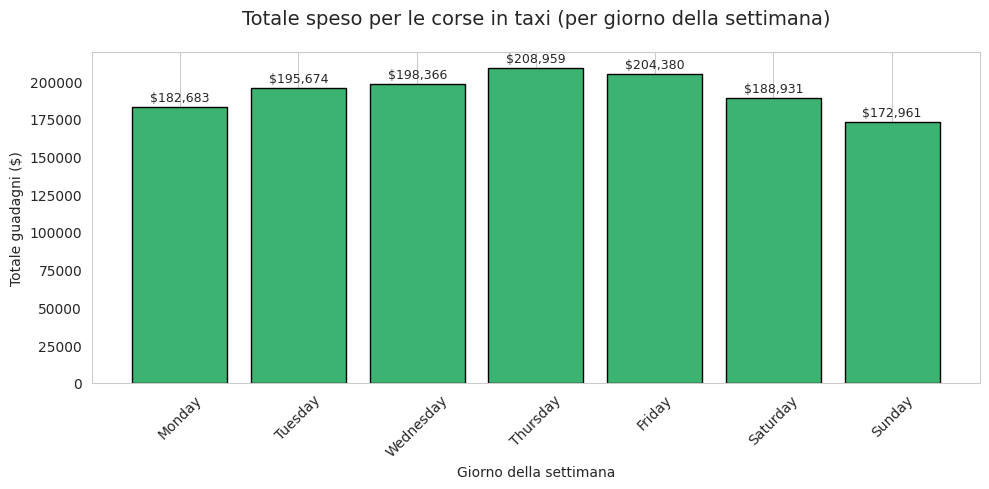

In [ ]:
# impostiamo lo stile
sns.set_style("whitegrid")

# creiamo colonna con giorno della settimana
df['giorno_settimana'] = df['pickup_datetime'].dt.day_name()

# calcoliamo i guadagni totali per giorno
guadagni_per_giorno = df.groupby('giorno_settimana')['fare_amount'].sum()

# ordiniamo i giorni
ordine_giorni = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
guadagni_per_giorno = guadagni_per_giorno.reindex(ordine_giorni)

# plot del grafico
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(guadagni_per_giorno.index, guadagni_per_giorno.values, color='mediumseagreen', edgecolor='black')

# aggiungiamo etichette sopra le barre
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2000, f"${int(height):,}", ha='center', va='bottom', fontsize=9)

# titoli ed etichette
ax.set_title("Totale speso per le corse in taxi (per giorno della settimana)", fontsize=14, pad = 20)
ax.set_xlabel("Giorno della settimana")
ax.set_ylabel("Totale guadagni ($)")
plt.xticks(rotation=45)
ax.grid(axis='y')
plt.tight_layout()
plt.show()


Dal barplot possiamo notare come i giorni feriali centrali siano i più redditizi, forse a causa di lavoro, traffico urbano, commissioni, spostamenti diurni e serali.

I picchi mercoledì/venerdì suggeriscono un’accumulazione di attività pre-weekend.

Sabato ha meno spesa del previsto:
Può indicare tante corse brevi, magari notturne, con importi più bassi.

Domenica è il giorno più “debole”:
Meno persone in giro, meno traffico urbano.
Forse meno attività lavorative e meno eventi.


Tuttavia, rimane la possibilità che questa diminuzione sia dovuta a un bias nel campionamento: abbiamo quindi deciso di visualizzare il numero totale di corse effettuate in ciascun giorno della settimana.

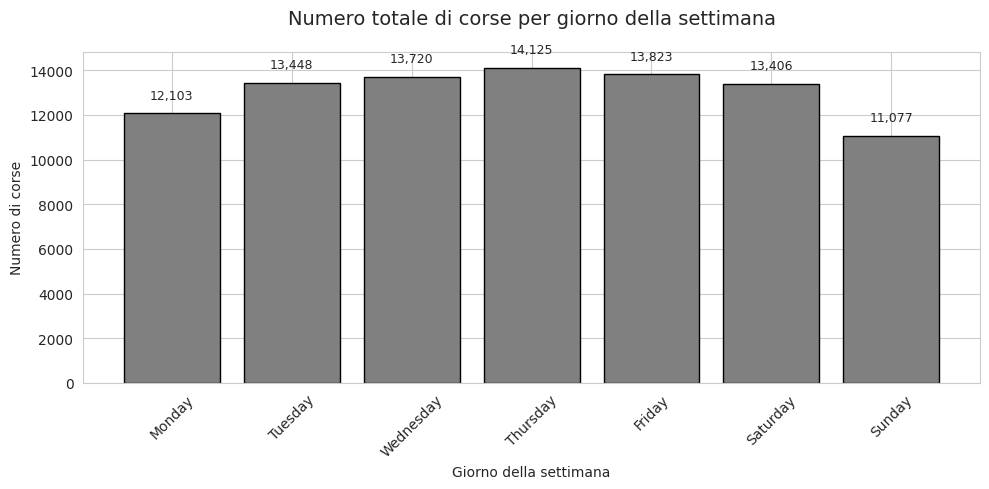

In [ ]:
# impostiamo lo stile del grafico
sns.set_style("whitegrid")

# calcolo delle corse per giorno
corse_per_giorno = df['giorno_settimana'].value_counts().reindex(ordine_giorni)

# barplot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(corse_per_giorno.index, corse_per_giorno.values, color='grey', edgecolor='black')

# etichette
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 500, f"{int(height):,}", ha='center', va='bottom', fontsize=9)

# titoli e assi
ax.set_title("Numero totale di corse per giorno della settimana", fontsize=14, pad = 20)
ax.set_xlabel("Giorno della settimana")
ax.set_ylabel("Numero di corse")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Da questa analisi di può effettivamente notare la presenza un calo nel fine settimana, in particolare la domenica.
Una spiegazione plausibile potrebbe essere la minore presenza di lavoratori in circolazione durante il weekend.

Tuttavia, sabato e domenica presentano un numero significativamente inferiore di corse rispetto ai giorni feriali (fino a 3.000 corse in meno).

Questo potrebbe indicare una sottorappresentazione dei dati del weekend nel campione analizzato, suggerendo che il calo nei guadagni possa essere in parte influenzato da un bias del dataset, e non riflettere pienamente la realtà.

Possiamo inoltre analizzare la media delle variabili `fare_amount` e `tip_amount` raggruppate per mese, in modo da vedere in quale mese il guadagno è maggiore

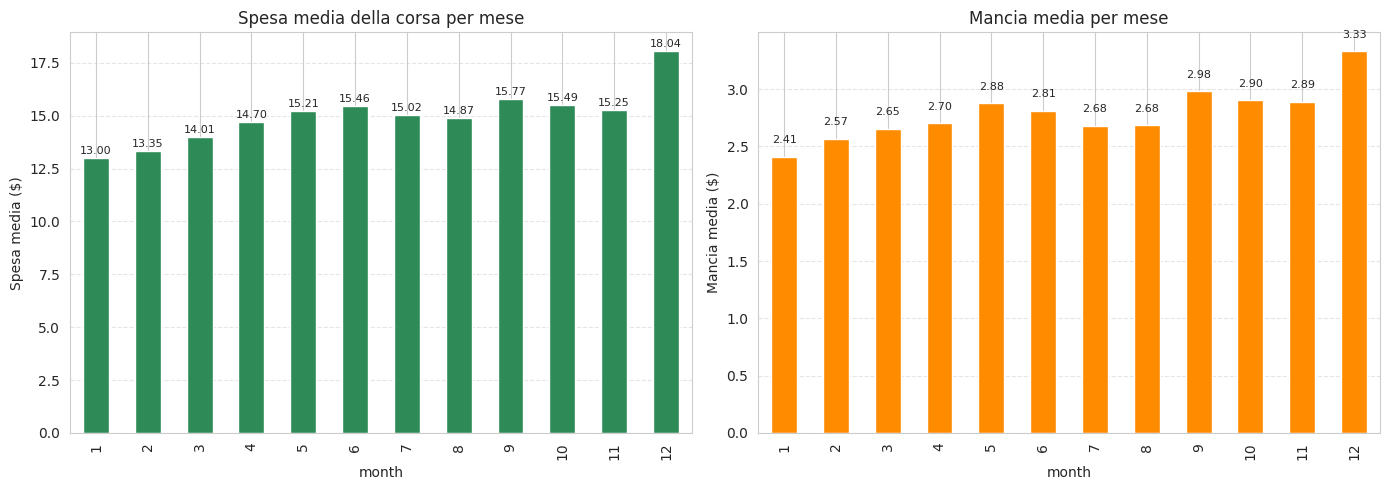

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# barplot
df.groupby('month')['fare_amount'].mean().plot(kind='bar', ax=axes[0], color='seagreen', ylabel='Spesa media ($)')
df.groupby('month')['tip_amount'].mean().plot(kind='bar', ax=axes[1], color='darkorange', ylabel='Mancia media ($)')

# titoli
axes[0].set_title("Spesa media della corsa per mese")
axes[1].set_title("Mancia media per mese")

# etichette
for ax in axes:
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.2f}", ha='center', va='bottom', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Dal primo grafico notiamo come il przzo medio tenda ad aumentare durante l'anno.
I valori più alti si osservano a partire da agosto e soprattutto a dicembre, che mostra un picco molto evidente.
Quest'ultimo potrebbe essere legato a maggior traffico cittadino (es. shopping natalizio) o richiesta maggiore nel periodo delle feste.

Anche le mance seguono un trend crescente, con dicembre che si riconferma il mese con le mance più cospicue, indicando magari una generosità stagionale da periodo pre-natalizio, o, semplicemente, presenza di più turisti (che spesso tendono a dare mance maggiori).

Si nota anche un piccolo salto a settembre-ottobre, forse legato alla ripresa dell’attività urbana post estate.

Ricordiamo comunque che i record di dicembre sono nettamente inferiori.

Per concludere l'analisi di stagionalità abbiamo deciso di generare una heatmap che rappresentasse la media della variabile `fare_amount` di ogni settimana, per ogni mese, in modo da analizzare se ci sono settimane di base più redditizie.

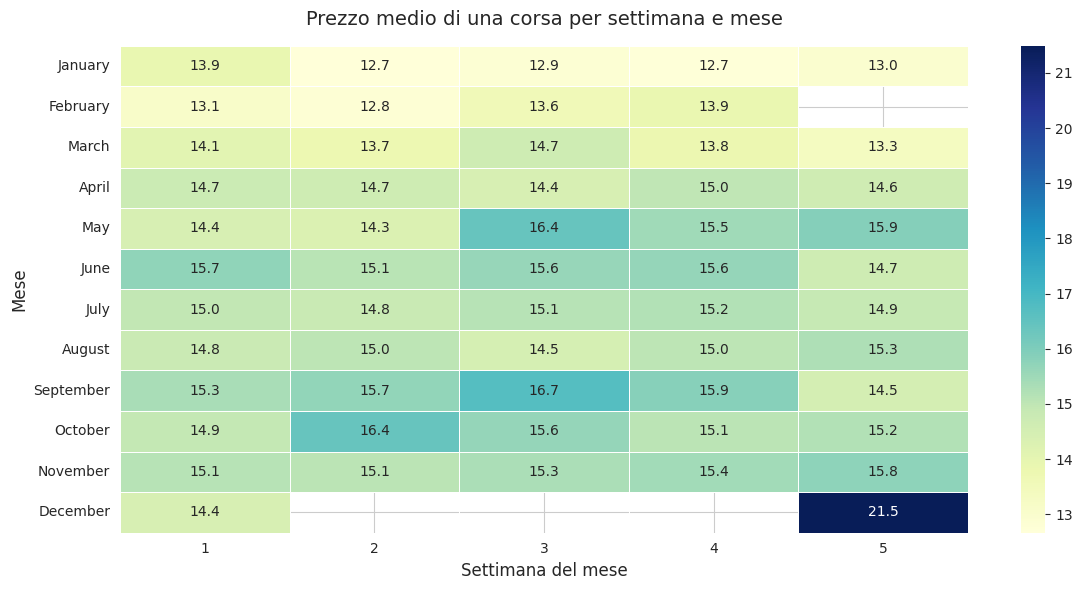

In [ ]:
import calendar

# estraiamo giorno e settimana del mese
df['giorno'] = df['pickup_datetime'].dt.day
df['settimana_mese'] = (df['giorno'] - 1) // 7 + 1

# calcoliamo la media per settimana/mese
media_fare_settimana_mese = df.groupby(['month', 'settimana_mese'])['fare_amount'].mean().unstack()
media_fare_settimana_mese.index = [calendar.month_name[m] for m in media_fare_settimana_mese.index]

# plot
plt.figure(figsize=(12, 6))
sns.heatmap(media_fare_settimana_mese, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=0.5, linecolor='white')
plt.title("Prezzo medio di una corsa per settimana e mese", fontsize=14, pad=15)
plt.xlabel("Settimana del mese", fontsize=12)
plt.ylabel("Mese", fontsize=12)
plt.tight_layout()
plt.show()

SI ripropone il problema legato al mese di dicembre: a quanto pare non esistono record appartenenti alle settimane due, tre e quattro. Inoltre il valore della quinta settimana è di gran lunga il più alto della heatmap.

Ora procederemo con il disegnare su un grafico le medie di `fare_amount` diviso per settimana.

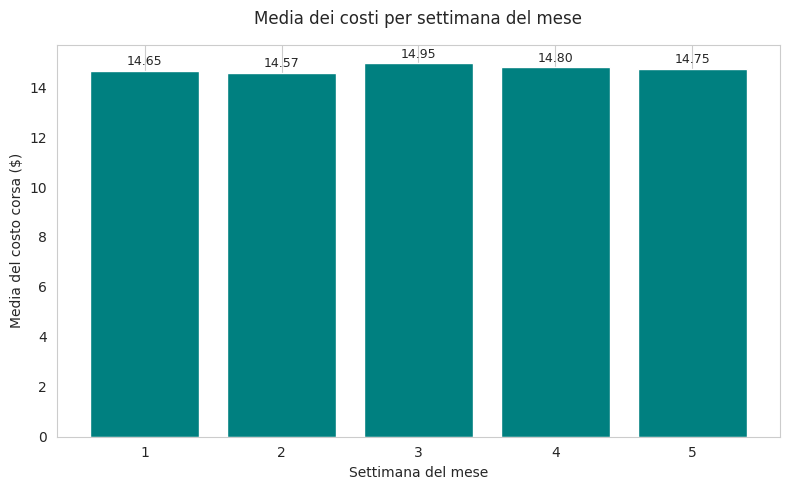

In [ ]:
media_per_settimana = df.groupby('settimana_mese')['fare_amount'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(media_per_settimana.index, media_per_settimana.values, color='teal')

# etichette
for bar in bars:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height + 0.1, f"{height:.2f}", ha='center', va='bottom', fontsize=9)


# titoli e assi
ax.set_title("Media dei costi per settimana del mese", pad=15)
ax.set_xlabel("Settimana del mese")
ax.set_ylabel("Media del costo corsa ($)")
ax.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


L’analisi della variabile `fare_amount` in funzione della settimana del mese evidenzia una stagionalità intra-mensile molto contenuta.

Dalla heatmap mensile-settimanale emerge che in alcuni mesi — come maggio, settembre e dicembre — ci sono settimane con medie sensibilmente più alte, suggerendo la possibile influenza di eventi stagionali, festività o variazioni nella domanda (es. vacanze, stipendi, turismo).

Tuttavia, il grafico aggregato della media del `fare_amount` per settimana del mese mostra valori molto simili tra loro, compresi tra circa 14.6 e 14.9 $. Questo suggerisce che, nell’intero anno, non esistono differenze marcate tra le settimane 1–5 dal punto di vista economico medio.

Conclusione stagionalità:

Esistono leggere oscillazioni locali (visibili nella heatmap), ma non si osserva un pattern settimanale forte e ricorrente. La stagionalità settimanale è quindi presente ma debole, e potrebbe essere mascherata dalla natura casuale del campione o dalla stagionalità mensile più dominante.



---



### ⁉️ 2.6 Viaggi anomali: durate molto lunghe per brevi distanze

Questa parte dell'analisi si concentrerà sulla rilevazione di eventuali outliers: iniziamo con il disegnare due boxplot per rappresentare le variabili `trip_distance` e `time_duration`

<Axes: xlabel='time_duration'>

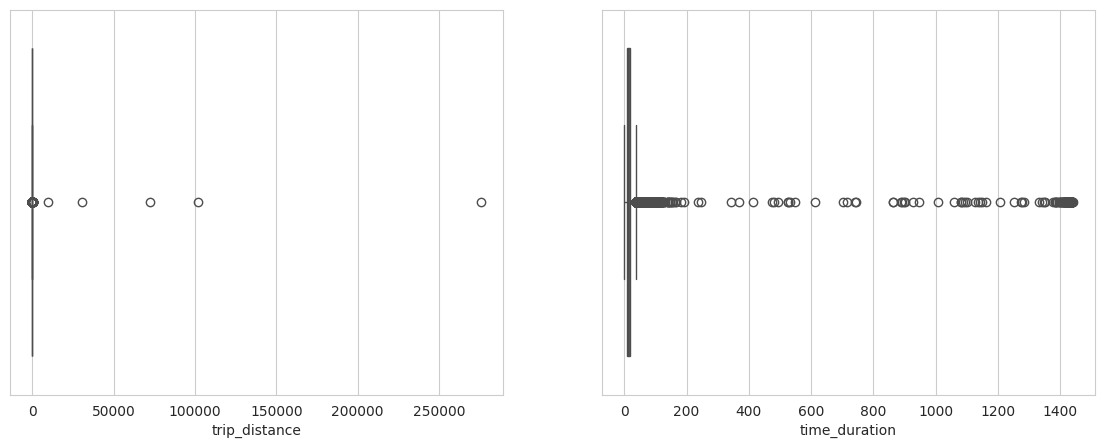

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x=df['trip_distance'], ax=axes[0], color='blue')
sns.boxplot(x=df['time_duration'], ax=axes[1], color='red')

A causa della  forte presenza di outliers non si riesce a visualizzare bene il grafico, quindi lo riproponiamo rimuovendo i valori troppo alti

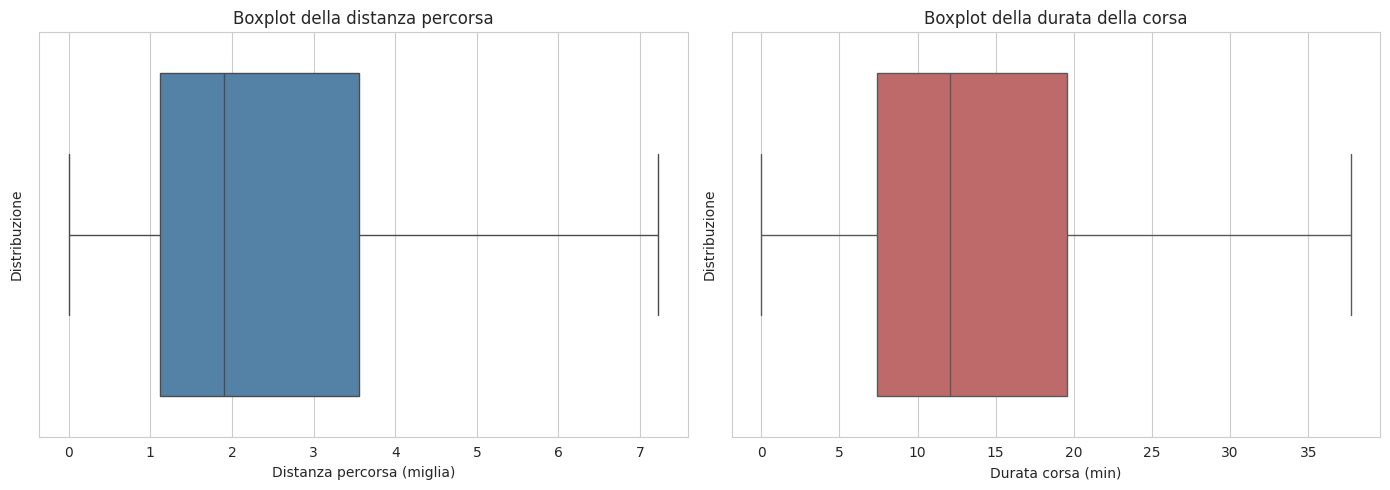

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# boxplots
sns.boxplot(x=df['trip_distance'], ax=axes[0], color='steelblue', showfliers=False)
sns.boxplot(x=df['time_duration'], ax=axes[1], color='indianred', showfliers=False)

# titoli e assi
axes[0].set_title("Boxplot della distanza percorsa")
axes[0].set_xlabel("Distanza percorsa (miglia)")
axes[0].set_ylabel("Distribuzione")

axes[1].set_title("Boxplot della durata della corsa")
axes[1].set_xlabel("Durata corsa (min)")
axes[1].set_ylabel("Distribuzione")

plt.tight_layout()
plt.show()

Dai boxplot che abbiamo disegnato, su cui sono rappresentati le variabili `time_duration` e `trip_distance`, possiamo vedere che, in entrambi i grafici, il 50% dei valori centrali e in un intervallo molto stretto. Notiamo una forte presenza di outliers, ma solo a sinistra della distribuzione, il che indica distanze molto lunghe e tempistiche di viaggio altrettanto lunghe. Per sicurezza, cerchiamo eventuali record di brevi distanze ma alta durata.

In [ ]:
df[(df['trip_distance'] < 1) & (df['time_duration'] > 100)].shape[0]

34

con ogni probabilità, questi record rappresentano errori di registrazione o errori di input, poichè riportano corse della durata superiore a 100 minuti
per distanze inferiori ad un kilometro

In [ ]:
elimina4 = df[(df['trip_distance'] < 1) & (df['time_duration'] > 100)]
df = df.drop(elimina4.index)



---



### 🫆2.7 Outlier nei prezzi con Z-score o IQR


Ora ci concentreremo sull'analisi dei valori anomali nella variabile `fare_amount`

In [ ]:
# Calcolo quartili
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

# Definizione delle soglie
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificazione outlier
outlier_mask = (df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)
outlier_count = outlier_mask.sum()

print(f"IQR =: {IQR}")
print(f"Outlier rilevati: {outlier_count}")
print(f"Soglie: inferiore = {lower_bound:.2f}, superiore = {upper_bound:.2f}")


IQR =: 9.0
Outlier rilevati: 9577
Soglie: inferiore = -6.50, superiore = 29.50


Dopo aver calcolato l'IQR, abbiamo calcolato delle soglie per definire i limiti accettabili per i valori.
Poi, tramite una maschera booleana che identifica tutte le righe in cui `fare_amount` è minore della soglia inferiore o maggiore della soglia superiore, contiamo il numero totale di outlier rilevati.

Ovviamente prendiamo in considerazione soo la soglia superiore, pari a 29.50 dollari.



Ora disegnamo un grafico a dispersione che mostra la relazione tra `fare_amount` e `trip_distance`, evidenziando i valori classificati come outlier rispetto alla distribuzione di `fare_amount`. I punti anomali sono stati evidenziati in rosso, mentre gli altri in blu.

Questa visualizzazione consente di comprendere se i valori anomali del costo della corsa sono anche associati a distanze atipiche, suggerendo possibili errori di registrazione, oppure se rappresentano viaggi effettivamente lunghi ma coerenti (es. spostamenti da/per aeroporti).

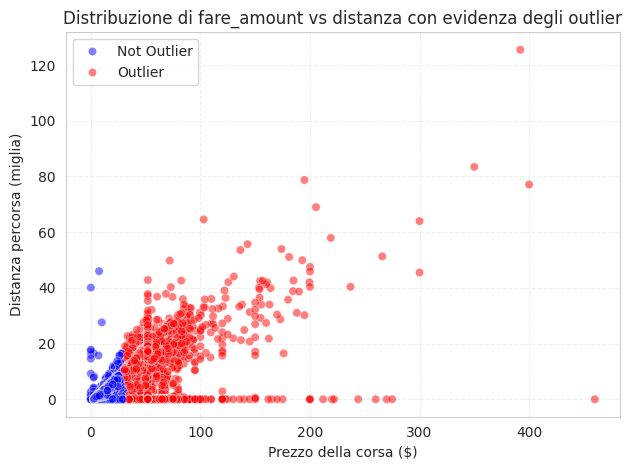

In [ ]:
is_outlier = (df["fare_amount"] < Q1 - 1.5*IQR) | (df["fare_amount"] > Q3 + 1.5*IQR)

is_outlier = is_outlier.map({True: "Outlier", False: "Not Outlier"})

sns.scatterplot(x="fare_amount", y = "trip_distance", data = df[df["trip_distance"] < 1000], alpha = 0.5, hue = is_outlier, palette={"Outlier": "red", "Not Outlier": "blue"})
plt.xlabel("Prezzo della corsa ($)")
plt.ylabel("Distanza percorsa (miglia)")
plt.title("Distribuzione di fare_amount vs distanza con evidenza degli outlier")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="")

plt.tight_layout()
plt.show()

Mettendo in relazione gli attributi `fare_amount` e `trip_distance` in uno scatterplot, notiamo come molti degli outlier di `fare_amount` in realtà corrispondano ad elevate distanze percorse.



---



## **3. Modelli di predizione**

Lo scopo è sviluppare un modello predittivo che permetta di prevedere la spesa sostenuta per ogni corsa in base a delle variabili decisionali.

###🏋🏻‍♂️ 3.1 Preprocessing

Iniziamo il preprocessing dei dati rimuovendo tutti i record con il numero di passeggeri uguale a 0, in quanto si tratta di un dato irrealistico.

In [ ]:
# creiamo un nuovo dataframe da utilizzare apposta per il modello predittivo
indici_passeggeri_0 = df[df["passenger_count"] == 0].index
print(f"Ci sono {indici_passeggeri_0.shape[0]} osservazioni con numero di passeggeri uguale a zero.")
df_clean = df.drop(indici_passeggeri_0)


Ci sono 1850 osservazioni con numero di passeggeri uguale a zero.


Ripresentiamo l’istogramma della variabile `trip_distance`, ritenuta una delle più rilevanti per il nostro modello. Tuttavia, la presenza di numerosi outlier e la forte asimmetria della distribuzione rendono difficile una visualizzazione efficace. Per questo motivo, applichiamo una trasformazione logaritmica all’asse x, al fine di rappresentare meglio l’intera gamma di valori e migliorare la leggibilità del grafico.

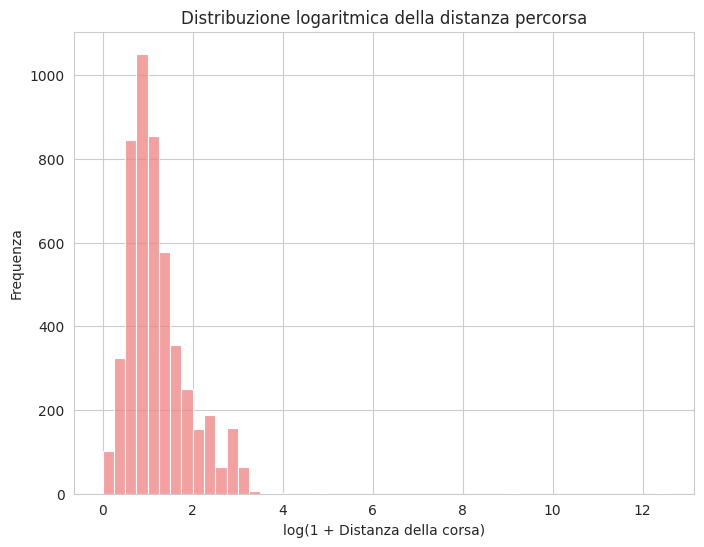

In [ ]:
import numpy as np

plt.figure(figsize=(8, 6))
sns.histplot(x=np.log1p(df_clean["trip_distance"].sample(5000, random_state=42)), bins=50, kde=False, color='lightcoral')
plt.xlabel("log(1 + Distanza della corsa)")
plt.ylabel("Frequenza")
plt.title("Distribuzione logaritmica della distanza percorsa")
plt.grid(True)
plt.show()


La distribuzione di trip_distance è fortemente asimmetrica verso destra (right-skewed).

La maggior parte delle corse si concentra tra 0 e 5 miglia, con un picco netto attorno a 1 miglio.

Oltre le 10 miglia, il numero di corse diminuisce drasticamente, anche se esistono alcuni valori estremi fino a oltre 50 miglia.

La presenza di valori isolati sopra i 30-40 miglia potrebbe indicare outlier o casi rari (es. trasferimenti aeroportuali o errori di registrazione). Nonostante il modello di random forest abbia meno problemi nella gestione di outliers, decidiamo comunque di rimuoverli.


In [ ]:
print(df_clean[df_clean["trip_distance"] > 50].shape[0])
df_clean = df_clean.dropna()

18


In [ ]:
#rimuoviamo le righe dove la distanza percorsa eccede i 50km

df_clean = df_clean[df_clean["trip_distance"] < 50]

Per arricchire i nostri modelli, generiamo una variabile categorica sull'orario della giornata: inglobiamo l'informazione sull'ora della corsa in una variabile dummy `rush_hour`, che è uguale a 1 se l'orario è considerato 'di punta' (tra le 15 e le 19) e 0 altrimenti.

<Axes: ylabel='fare_amount'>

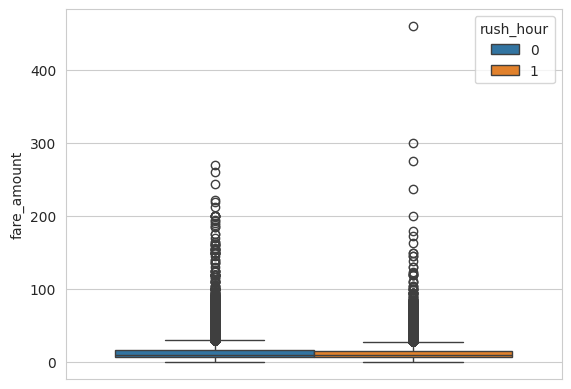

In [ ]:
#creiamo la variabile dummy rush_hour e plottiamo fare_amount
import numpy as np

df_clean['rush_hour'] = np.where(df_clean['trip_hour'].between(15, 19), 1, 0)
sns.boxplot(y = df_clean["fare_amount"], hue = df_clean["rush_hour"])

Notiamo che ci sono valori più estremi nel boxplot riferito alla variabile dummy uguale a zero. Questo magari può essere dovuto al fatto che le corse più lunghe, e di conseguenza più costose, come andare in aereoporto, vengono fatte preferibilmente nelle prime ore del mattino



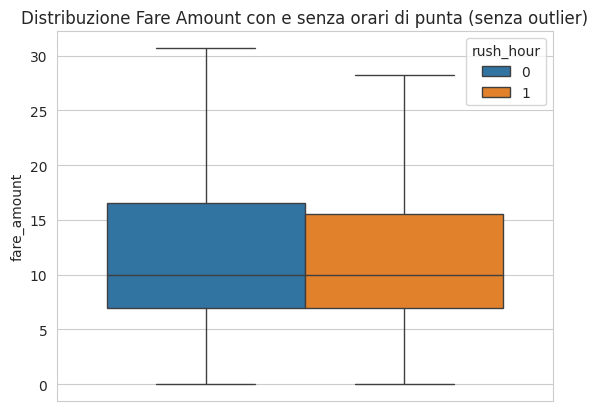

In [ ]:
#siamo interessati a vedere i valori dei boxplot da più vicino

sns.boxplot(
    y = df_clean["fare_amount"],
    hue = df_clean["rush_hour"],
    showfliers = False  # <--- Nasconde i valori outlier nel grafico
)
plt.title("Distribuzione Fare Amount con e senza orari di punta (senza outlier)")
plt.show()

Le due distribuzioni risultano pressochè identiche

In [ ]:
# vediamo quante osservazioni ci sono nelle due categorie
df_clean.groupby("rush_hour")["pickup_datetime"].count()

,pickup_datetime
rush_hour,
0,60449
1,29351


Adesso, ridisegnamo lo scatterplot che mette in relazione la distanza e il prezzo, mettendo in evidenza i punti secondo la variabile `rush_hour`


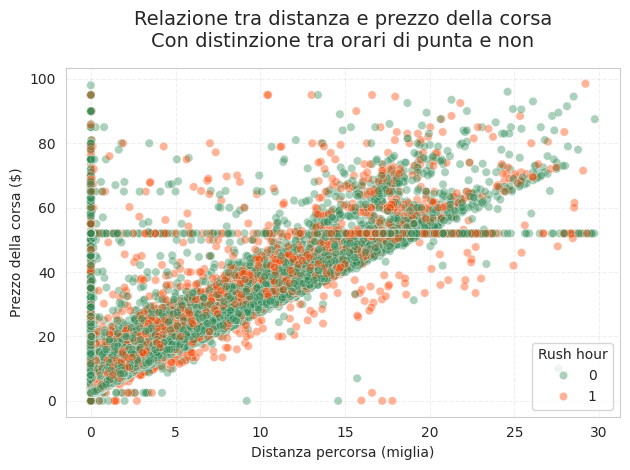

In [ ]:
sns.scatterplot(
    x="trip_distance",
    y="fare_amount",
    hue="rush_hour",
    data=df_clean[(df_clean['trip_distance'] < 30) & (df_clean['fare_amount'] < 100)],
    alpha=0.4,
    palette={True: "orangered", False: "seagreen"}
)

plt.title("Relazione tra distanza e prezzo della corsa\nCon distinzione tra orari di punta e non", fontsize=14, pad=15)
plt.xlabel("Distanza percorsa (miglia)")
plt.ylabel("Prezzo della corsa ($)")
plt.legend(title="Rush hour", loc="lower right")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Come vevamo già notato, si osserva una chiara correlazione positiva: al crescere della distanza, aumenta anche il costo della corsa

I punti sono colorati in base a `rush_hour` (verde = fuori orario punta, arancione = orario punta).

Visivamente, non ci sono grandi differenze nel costo tra corse durante e fuori dall’orario di punta

Questo conferma l’intuizione precedente che `rush_hour` potrebbe non avere un impatto forte sul `fare_amount`.

Tuttavia, il colore mostra che le corse sono distribuite abbastanza uniformemente tra i due orari.

Si nota una linea orizzontale attorno ai 52-54 dollari, che indica un possibile
prezzo fisso, ad esempio da/verso l’aeroporto o un limite di prezzo imposto da qualche regola tariffaria

Potrebbe essere interessante filtrare o trattare separatamente queste corse nel modello.

Come predictors utilizzeremo le variabili `trip_distance`, `fare_amount` e `time_duration`. Iniziamo analizzando l'indice di correlazione di Pearson attraverso una matrice di correlazione

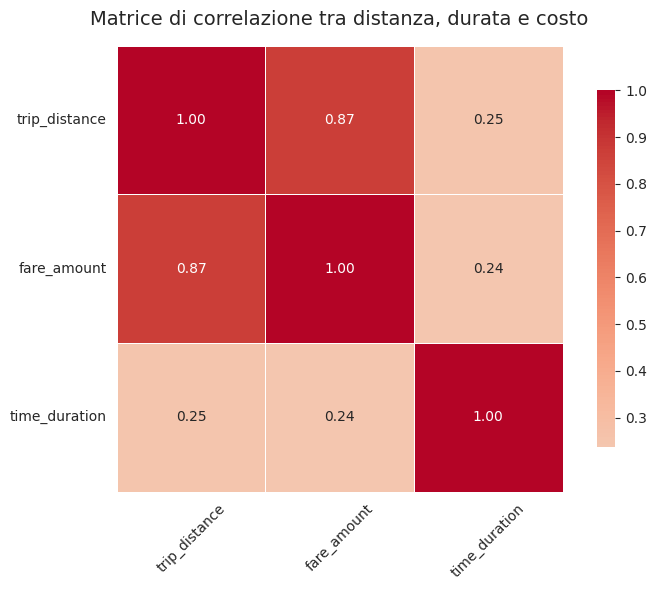

In [ ]:
# creiamo un nuovo dataframe per ottenere la matrice di correlazione e heatmap
df_clean_numeric = df_clean[["trip_distance", "fare_amount", "time_duration"]]
correlation_matrix_clean = df_clean_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix_clean,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title('Matrice di correlazione tra distanza, durata e costo', fontsize=14, pad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Notiamo che c'è un' alta correlazione positiva tra `fare_amount` e `trip distance`, come avevamo già dedotto. Le altre correlazioni sono debolmente positive.



---



### 🌱 3.2. Training del modello Random Forest

Per predirre la variabile `fare_amount` ci siamo affidati al Random Forest, un algoritmo basato su un insieme di alberi decisionali.
Ci è sembrato il più adatto, in quanto risulta particolarmente robusto agli outlier e non richiede normalizzazione delle variabili.
Al fine di valutare la capacità predittiva del modello selezionato, è stata implementata una validazione incrociata a 5 fold.
Il modello è stato allenato a partire da un sottoinsieme di variabili esplicative ritenute rilevanti: `trip_distance`,`time_duration`,`rush_hour`,`passenger_count`.

Il dataset è stato suddiviso in training set (80%) e test set (20%), mantenendo la casualità tramite un seme fisso (random_state=42).

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import time

X = df_clean[[ "trip_distance", "time_duration", "rush_hour", 'passenger_count']]
y = df_clean["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth= 5, random_state=42)

# Esegui la cross-validation (5-fold, con scoring R^2)
start_time = time.time()
scores_r2 = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
scores_MSE = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
CV_time = time.time() - start_time

print("$R^2$ per ogni fold:", scores_r2)
print("$R^2$ medio:", np.mean(scores_r2))

print("---------------------------")

print("MSE per ogni fold:", -scores_MSE)
print("MSE medio:", np.mean(-scores_MSE))

print("---------------------------")

print("The CV time is:", CV_time)


$R^2$ per ogni fold: [0.85473926 0.83954837 0.80178951 0.80468651 0.8223154 ]
$R^2$ medio: 0.8246158095428674
---------------------------
MSE per ogni fold: [24.83909595 29.14890867 38.7571063  38.49668373 31.27222361]
MSE medio: 32.502803650306504
---------------------------
The CV time is: 45.945802450180054


Il coefficiente di determinazione $R^2$ misura quanta varianza della variabile target è spiegata dal modello.

I valori sono molto alti: questo indica una buona capacità del modello di generalizzare e spiegare il comportamento della variabile target.

$R^2$ medio = 0.857 → in media, il modello spiega circa l’85.7% della variabilità del prezzo delle corse nei dati di training.

L’errore quadratico medio (MSE) misura la media degli errori al quadrato tra valore predetto e valore reale.

Essendo espresso in dollari², un MSE di 25.32 corrisponde a un errore standard di circa √25.32 ≈ 5.03 dollari.

Il modello quindi, in media, sbaglia di circa 5$ a corsa, il che può essere considerato accettabile in un contesto urbano con tariffe variabili.

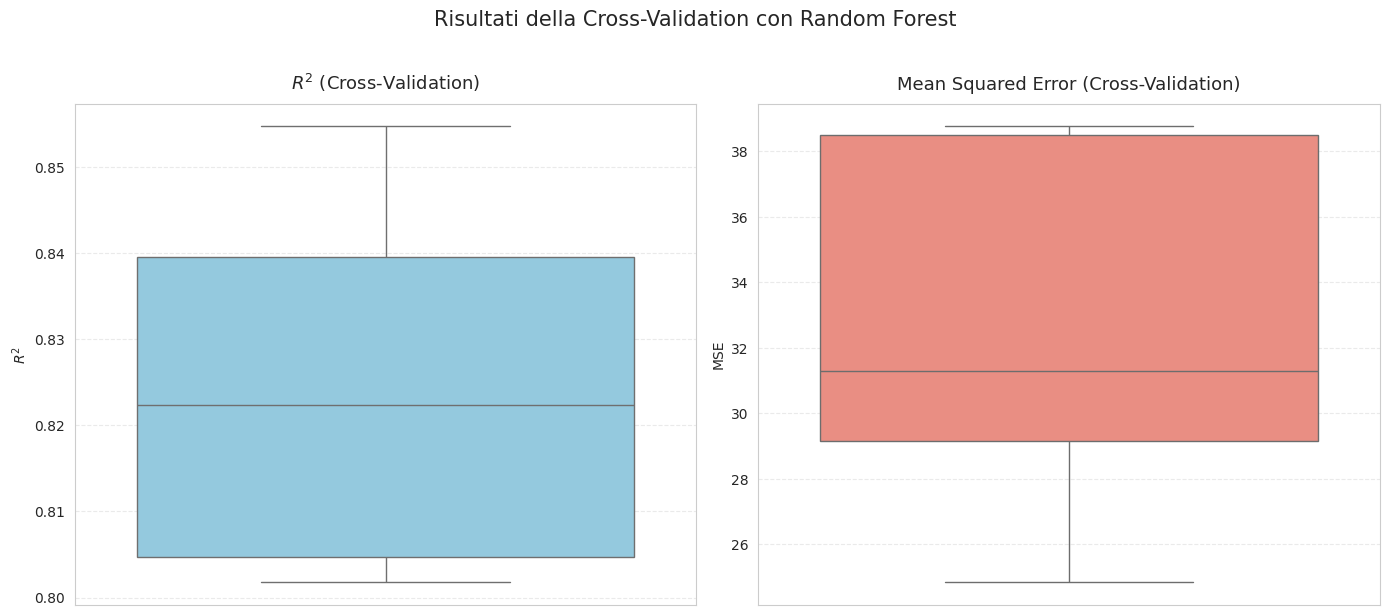

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot R²
sns.boxplot(y=scores_r2, ax=axes[0], color='skyblue')
axes[0].set_title("$R^2$ (Cross-Validation)", fontsize=13, pad=10)
axes[0].set_ylabel("$R^2$")
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Boxplot MSE (valori negativi convertiti in positivi)
sns.boxplot(y=-scores_MSE, ax=axes[1], color='salmon')
axes[1].set_title("Mean Squared Error (Cross-Validation)", fontsize=13, pad=10)
axes[1].set_ylabel("MSE")
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle("Risultati della Cross-Validation con Random Forest", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()


Abbiamo anche deciso di rappresentare i risultati dei valori calcolati dalla cross-validation dell' $R^2$ e dell'MSE

Abbiamo deciso di sviluppare un secondo modello predittivo per la variabile fare_amount, basato sul metodo della regressione lineare. Anche in questo caso, le performance del modello sono state valutate tramite una validazione incrociata a 5 fold, al fine di garantire una stima robusta della sua capacità di generalizzazione.

In [ ]:
from sklearn.linear_model import LinearRegression
import time

X = df_clean[[ "trip_distance", "time_duration"]]
y = df_clean["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()

start_time = time.time()

# Esegui la cross-validation (5-fold, con scoring R^2)
scores_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
scores_MSE = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CV_time = time.time() - start_time

print("$R^2$ per ogni fold:", scores_r2)
print("$R^2$ medio:", np.mean(scores_r2))

print("---------------------------")

print("MSE per ogni fold:", -scores_MSE)
print("MSE medio:", np.mean(-scores_MSE))

print("---------------------------")

print("The CV time is:", CV_time)



$R^2$ per ogni fold: [0.78535182 0.75652747 0.74340798 0.71417921 0.75671745]
$R^2$ medio: 0.7512367866870028
---------------------------
MSE per ogni fold: [36.70411243 44.23114111 50.17274339 56.33585614 42.81736415]
MSE medio: 46.052243444901094
---------------------------
The CV time is: 0.11196303367614746


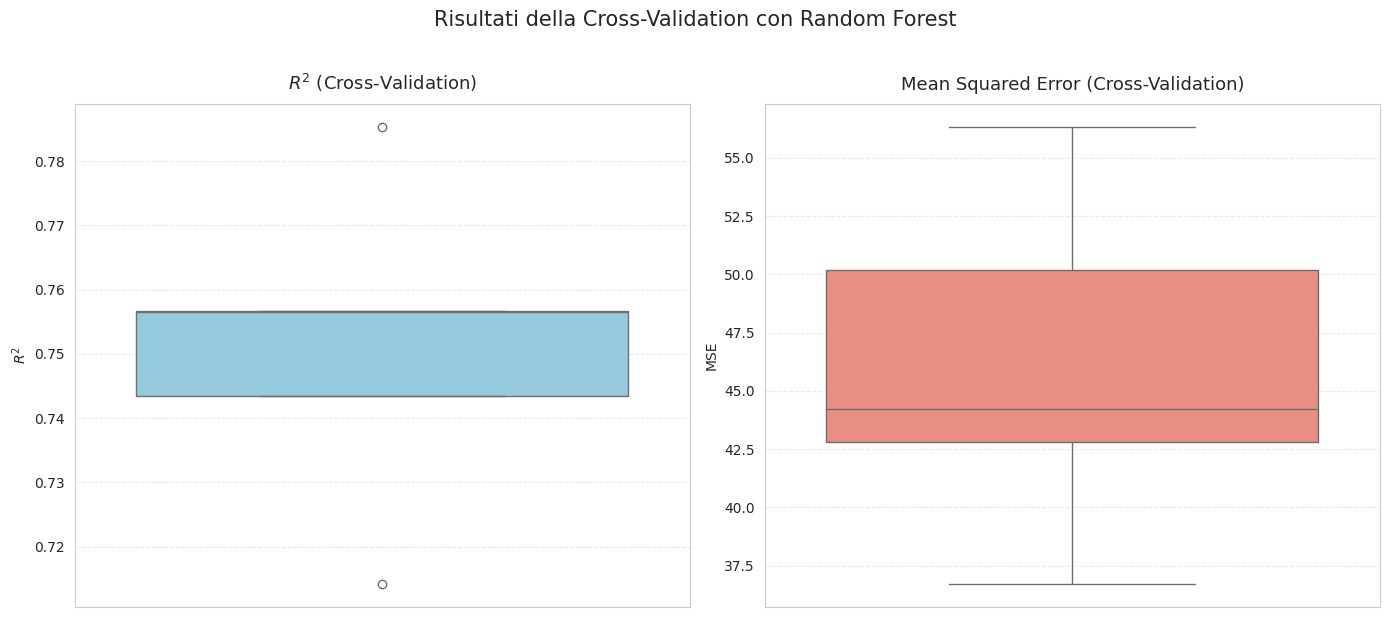

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot R²
sns.boxplot(y=scores_r2, ax=axes[0], color='skyblue')
axes[0].set_title("$R^2$ (Cross-Validation)", fontsize=13, pad=10)
axes[0].set_ylabel("$R^2$")
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Boxplot MSE (valori negativi convertiti in positivi)
sns.boxplot(y=-scores_MSE, ax=axes[1], color='salmon')
axes[1].set_title("Mean Squared Error (Cross-Validation)", fontsize=13, pad=10)
axes[1].set_ylabel("MSE")
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle("Risultati della Cross-Validation con Random Forest", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

Il modello di regressione lineare ha ottenuto buoni risultati, con un $R^2$ medio pari a 0.78 e un errore medio di circa 6.2 dollari a corsa.



---



### 🌳 3.3 Modello di random forest

Dopo che abbiamo valutato le performance dei due modelli, procediamo con la valutazione del test set.

In [ ]:
# importiamo le librerie

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# selezioniamo le variabili che potrebbero essere più influenti per il modello
# dividiamo in training e test

X = df_clean[["passenger_count", "trip_distance", "time_duration", "rush_hour"]]
y = df_clean["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100,max_depth= 5, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [ ]:
#Test the results
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

print("------------------------")

# Estrai l'importanza delle feature
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values(by="Importance", ascending=False)

print(feature_importance)

print("------------------------")

r2 = r2_score(y_test, predictions)
print("R²:", r2)


Mean Squared Error: 23.65794943091707
------------------------
           Feature  Importance
1    trip_distance    0.891598
2    time_duration    0.104611
0  passenger_count    0.003542
3        rush_hour    0.000250
------------------------
R²: 0.8707009594776762


Il modello ha mostrato ottime capacità predittive, con un errore medio di circa 4.85 dollari e un $R^2$ superiore all’86%. L’analisi delle feature evidenzia che la distanza percorsa è di gran lunga la variabile più rilevante, mentre fattori come il numero di passeggeri o la fascia oraria (rush hour) risultano trascurabili nel determinare la tariffa. Ciò conferma che la tariffazione delle corse taxi è fortemente basata sulla distanza, e in misura minore sul tempo di percorrenza.

Proviamo adesso a sviluppare il modello senza la variabile `rush_hour`














In [ ]:
X = df_clean[["passenger_count", "trip_distance", "time_duration"]]
y = df_clean["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth= 5, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
#Test the results
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

print("------------------------")

# Estrai l'importanza delle feature
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values(by="Importance", ascending=False)

print(feature_importance)

print("------------------------")

r2 = r2_score(y_test, predictions)
print("R²:", r2)
# Il MSE si è leggermente abbassato



Mean Squared Error: 23.618734039558166
------------------------
           Feature  Importance
1    trip_distance    0.891766
2    time_duration    0.104692
0  passenger_count    0.003543
------------------------
R²: 0.8709152854272358


Dopo aver rimosso la variabile rush_hour, il modello ha mantenuto sostanzialmente le stesse performance predittive, con un MSE di circa 23.51 e un $R^2$ pari a 86.3%. Questo conferma che rush_hour aveva un impatto trascurabile sul modello, e che la sua esclusione non compromette l’accuratezza. Le variabili trip_distance e time_duration restano i principali predittori, mentre passenger_count ha un ruolo marginale. La semplificazione del modello risulta quindi efficace, mantenendo elevate prestazioni e migliorandone la leggibilità.


Adesso plottiamo un grafico che ci mostri la media della variabile far_amount per ogni numero di passeggeri per corsa

<ipython-input-55-ad58a7115a48>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
<ipython-input-55-ad58a7115a48>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


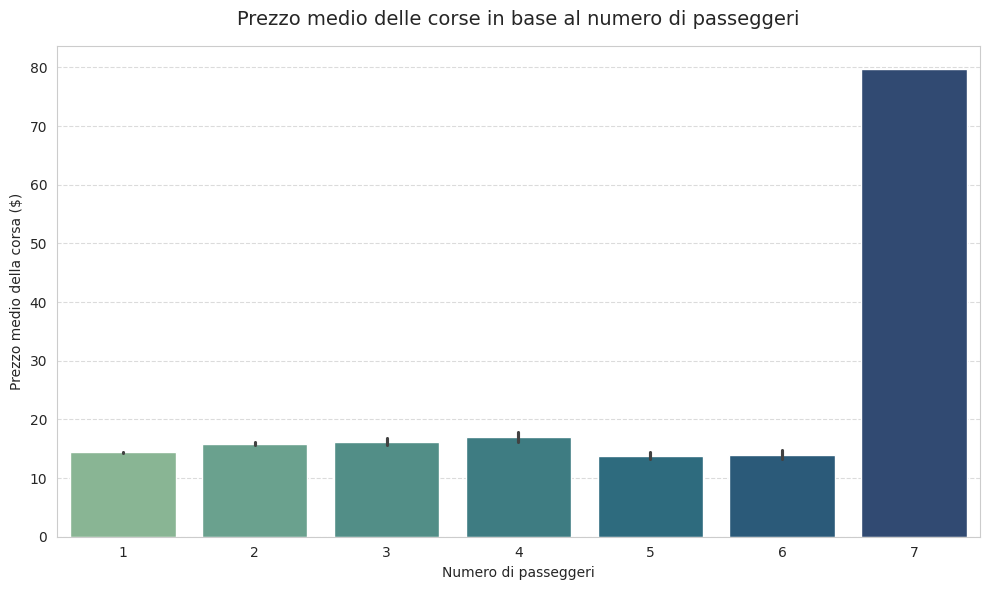

In [ ]:
df_clean['passenger_count_str'] = df_clean['passenger_count'].astype(str)
df_filtered = df_clean[(df_clean['passenger_count'] > 0) & (df_clean['passenger_count'] <= 6)]
order = sorted(df_clean['passenger_count'].unique())
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_clean,
    x='passenger_count',
    y='fare_amount',
    estimator=np.mean,
    order=order,
    palette='crest',
    ci=95
)

plt.title("Prezzo medio delle corse in base al numero di passeggeri", fontsize=14, pad=15)
plt.xlabel("Numero di passeggeri")
plt.ylabel("Prezzo medio della corsa ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# controlla il warning

Questo grafico mostra che il prezzo medio di una corsa taxi è relativamente indipendente dal numero di passeggeri, con ampia variabilità interna. Questa variabile ha quindi scarso potere predittivo ed è correttamente pesata poco nel modello. In particolare, le barre verticali nere rappresentano l'intervallo di confidenza al 95% della media.

Infine testiamo le capacità del modello senza la variabile passenger count:

In [ ]:
X = df_clean[[ "trip_distance", "time_duration"]]
y = df_clean["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth= 5, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
#Test the results
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

print("------------------------")

# Estrai l'importanza delle feature
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values(by="Importance", ascending=False)

print(feature_importance)

print("------------------------")

r2 = r2_score(y_test, predictions)
print("R²:", r2)


Mean Squared Error: 23.806211150384822
------------------------
         Feature  Importance
0  trip_distance    0.893619
1  time_duration    0.106381
------------------------
R²: 0.8698906568718081


Dopo aver rimosso anche la variabile passenger_count, il modello ha continuato a mantenere ottime performance, con un MSE di circa 23.44 e un $R^2$ pari all’86.4%. Questo risultato conferma che passenger_count, così come rush_hour, non apportava un contributo significativo alla predizione della tariffa. Il modello risulta ora più semplice e compatto, basandosi unicamente su trip_distance e time_duration, che si confermano le due variabili chiave nella determinazione del prezzo di una corsa.

Plottiamo uno scatterplot, in modo da visualizzare quanto le previsioni del modello si avvicinano ai dati reali, in base alla distanza percorsa.

Se i punti rossi (predetti) si sovrappongono o seguono da vicino i blu (reali) il modello sta funzionando bene.

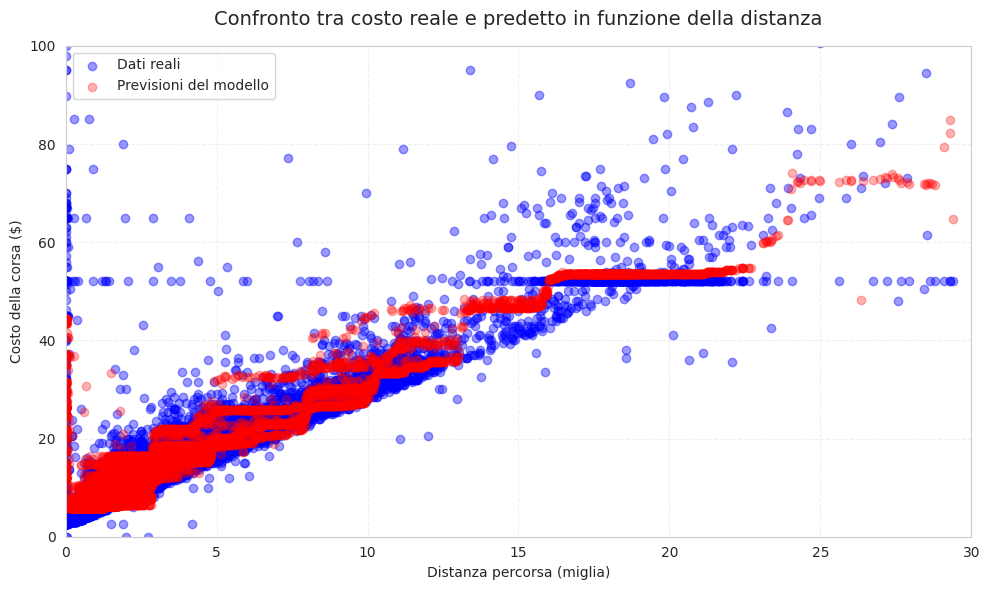

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter reali
plt.scatter(X_test['trip_distance'], y_test, color='blue', label='Dati reali', alpha=0.4)

# Scatter previsioni
plt.scatter(X_test['trip_distance'], predictions, color='red', label='Previsioni del modello', alpha=0.3)

# Aggiunta etichette
plt.title("Confronto tra costo reale e predetto in funzione della distanza", fontsize=14, pad=15)
plt.xlabel("Distanza percorsa (miglia)")
plt.ylabel("Costo della corsa ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 30)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


Il modello Random Forest riesce a catturare bene la relazione generale tra distanza e costo, specialmente nelle fasce centrali. Tuttavia, ha difficoltà a prevedere corse molto costose o molto brevi con prezzi alti, e tende a "concentrarsi" su valori più comuni, sottostimando gli outlier.

Facciamo la stessa cosa cambiando predictor

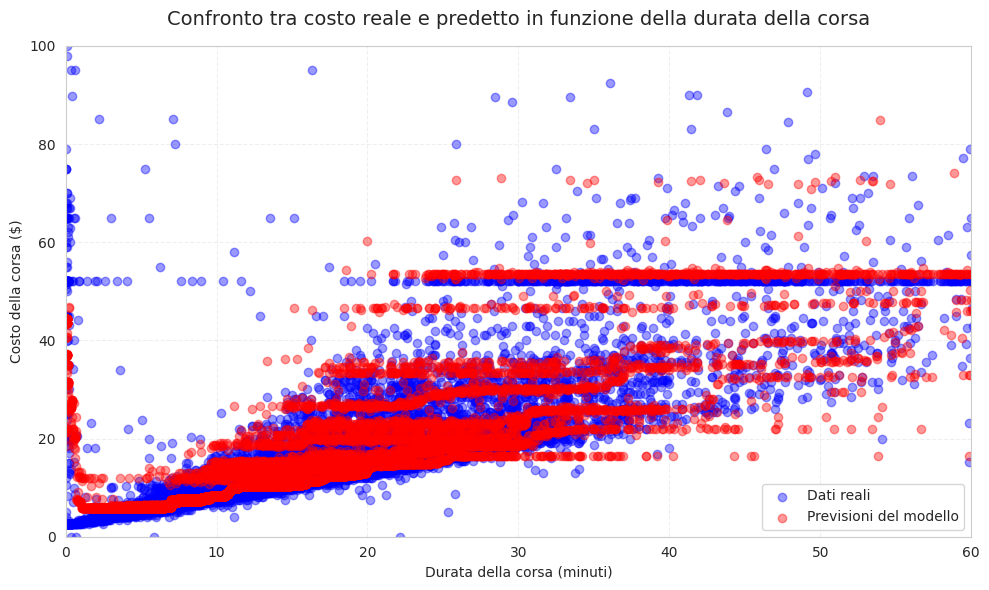

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter dei dati reali
plt.scatter(X_test['time_duration'], y_test, color='blue', label='Dati reali', alpha=0.4)

# Scatter delle previsioni
plt.scatter(X_test['time_duration'], predictions, color='red', label='Previsioni del modello', alpha=0.4)

# Titolo e assi
plt.title("Confronto tra costo reale e predetto in funzione della durata della corsa", fontsize=14, pad=15)
plt.xlabel("Durata della corsa (minuti)")
plt.ylabel("Costo della corsa ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Limiti opzionali
plt.xlim(0, 60)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


Il grafico mostra una buona capacità del modello nel catturare la relazione generale tra durata della corsa e costo, soprattutto per corse brevi. Tuttavia, per durate più lunghe, le previsioni tendono ad appiattirsi, indicando che il modello fatica a cogliere la variabilità reale dei dati. Ciò potrebbe dipendere sia dalla natura dei dati che dalla complessità del modello (Random Forest a bassa profondità), e suggerisce l’opportunità di testare ulteriori modelli .

### 📈 3.4 Regressione Lineare

Adesso proveremo a sviluppare un secondo modello predittivo utilizzando una regressione lineare

In [ ]:
#Modello con le variabili standardizzate: (togliere la costante)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

X = df_clean[[ "trip_distance", "time_duration"]]
y = df_clean["fare_amount"]


# Crea lo scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = pd.Series(scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten(), name="fare_amount")


# Riconverti in DataFrame mantenendo i nomi delle colonne
X_standardized = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_scaled, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Modello di regressione lineare
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

print("------------------------")

predictions = results.predict(X_test)

# Calcola l'MSE
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                 1.078e+05
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:01:09   Log-Likelihood:                -52175.
No. Observations:               71840   AIC:                         1.044e+05
Df Residuals:                   71837   BIC:                         1.044e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.002     -0.100

Il modello di regressione lineare con variabili standardizzate e costante spiega quasi l’80% della varianza del prezzo della corsa taxi. La distanza percorsa si conferma la variabile decisiva, mentre la durata ha un impatto secondario ma significativo. Il modello ha un MSE basso e diagnostica pulita, ma i residui mostrano non normalità, probabilmente dovuta alla presenza di outlier nel dataset.
Abbiamo inoltre provveduto a standardizzare le variabili perché avevano scale diverse (es. distanza e durata). In questo modo abbiamo reso i coefficienti confrontabili tra loro, migliorato la stabilità numerica della regressione e facilitato l’interpretazione dei risultati.

Ora plottiamo un grafico di regressione per vedere la relazione tra la distanza percorsa `trip_distance` e il costo della corsa `fare_amount`, confrontando i dati reali con le predizioni del modello lineare.

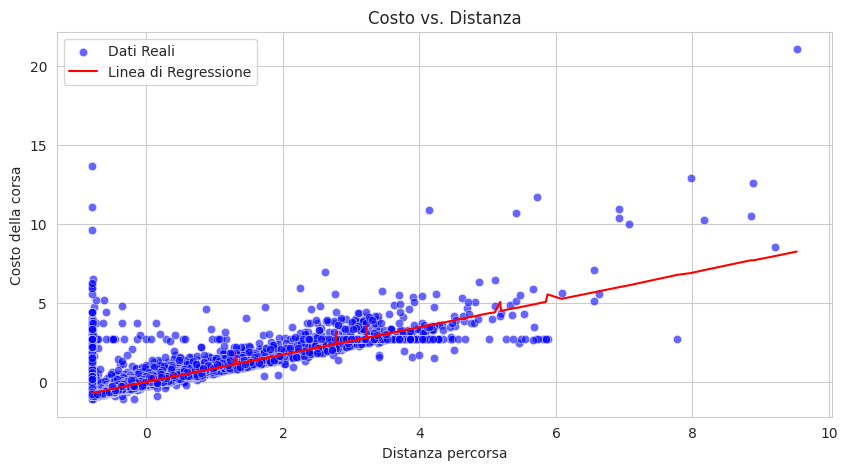

In [ ]:
# Regressione tra distanza e costo della corsa

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_test["trip_distance"], y=y_test, label="Dati Reali", color='blue', alpha=0.6)

# Ordinare i dati per la variabile indipendente
sorted_idx = X_test["trip_distance"].argsort()
sns.lineplot(x=X_test["trip_distance"].iloc[sorted_idx], y=predictions.iloc[sorted_idx], label="Linea di Regressione", color='red')

plt.title("Costo vs. Distanza")
plt.xlabel("Distanza percorsa")
plt.ylabel("Costo della corsa")
plt.legend()
plt.show()

Il grafico mostra una chiara relazione positiva tra la distanza percorsa e il costo della corsa: all'aumentare della distanza, il costo tende ad aumentare.

La linea rossa rappresenta la stima del modello lineare (in scala standardizzata), che cattura bene la tendenza media dei dati. Tuttavia:

I punti blu sono abbastanza dispersi, specialmente per distanze brevi, dove i prezzi variano anche notevolmente.

Alcuni punti si trovano molto lontani dalla linea: questi rappresentano probabilmente outlier, come corse brevi ma molto costose.

Il modello sembra sottostimare leggermente i valori più alti per distanze lunghe (oltre le 5 miglia), perché assume una crescita lineare, mentre nella realtà il prezzo potrebbe aumentare in modo non lineare (tariffe fisse, pedaggi, ecc.).

disegnamo una visualizzazione 3d

<ipython-input-62-151e69737b70>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
<ipython-input-62-151e69737b70>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_trip_distance = results.params[1]
<ipython-input-62-151e69737b70>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_time_duration = results.params[2]


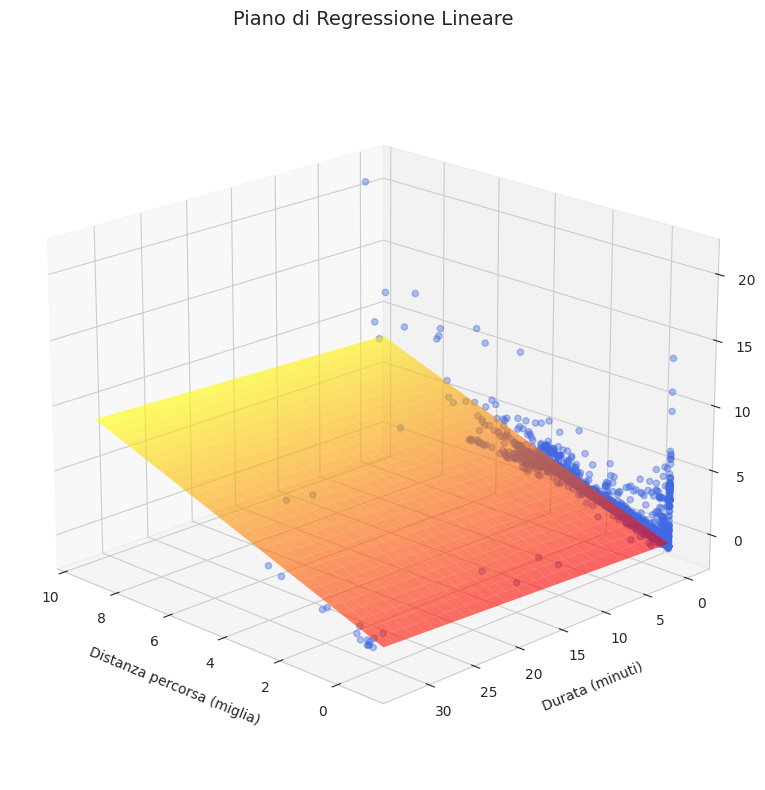

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# estraiamo i coefficienti dal modello
intercept = results.params[0]
coef_trip_distance = results.params[1]
coef_time_duration = results.params[2]

# creiamo il grafico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# scatter dei dati reali
ax.scatter(
    X_test["trip_distance"],
    X_test["time_duration"],
    y_test,
    color='royalblue',
    alpha=0.4,
    label='Dati reali'
)

# meshgrid
x_range = np.linspace(X_test["trip_distance"].min(), X_test["trip_distance"].max(), 30)
y_range = np.linspace(X_test["time_duration"].min(), X_test["time_duration"].max(), 30)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

# piano di regressione
z_mesh = intercept + coef_trip_distance * x_mesh + coef_time_duration * y_mesh
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='autumn', alpha=0.6, edgecolor='none')

# etichette
ax.set_xlabel('Distanza percorsa (miglia)', labelpad=10)
ax.set_ylabel('Durata (minuti)', labelpad=10)
ax.set_zlabel('Costo della corsa ($)', labelpad=10)
ax.set_title('Piano di Regressione Lineare', fontsize=14, pad=20)
ax.view_init(elev=20, azim=135)

plt.tight_layout()
plt.show()


Il grafico mostra il piano di regressione lineare che stima il costo della corsa a partire da distanza e durata. Il modello cattura la relazione lineare positiva tra queste variabili e il prezzo, ma la presenza di punti reali significativamente distanti dal piano suggerisce che esiste una certa variabilità nei dati non spiegata dal modello. Ciò indica che, pur essendo semplice e interpretabile, la regressione lineare ha dei limiti nell'adattarsi alla complessità dei dati reali.

Adfesso creiamo un grafico che ci mostra i residui, che rappresentano la distanza tra i valori effettivi e quelli predetti

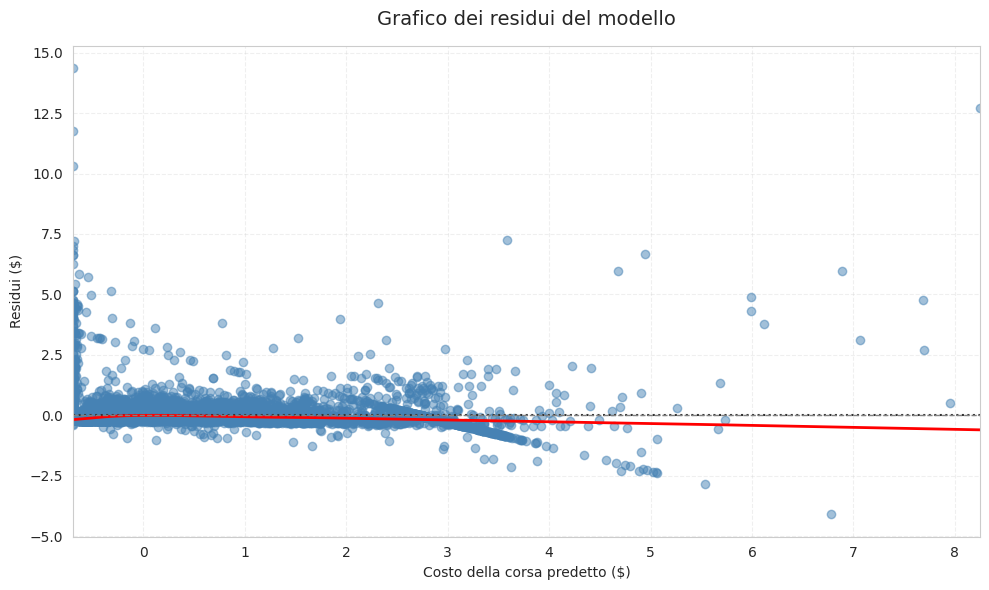

In [ ]:
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
sns.residplot(
    x=predictions,
    y=residuals,
    lowess=True,
    scatter_kws={'alpha': 0.5, 'color': 'steelblue'},
    line_kws={'color': 'red', 'lw': 2}
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Costo della corsa predetto ($)")
plt.ylabel("Residui ($)")
plt.title("Grafico dei residui del modello", fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


abbiamo anche aggiunto una curva di tendenza (smussata) per vedere se ci sono pattern sistematici nei residui

La linea rossa mostra il comportamento medio dei residui.
La distribuzione media dei residui centrata intorno allo 0
è un segnale che il modello non è sistematicamente sbilanciato verso sovra- o sotto-stima.

Nessun pattern fortemente ricorrente nella curva rossa indica che la relazione lineare è parzialmente rispettata.

Si nota una dispersione decrescente verso destra. I residui hanno varianza diversa per diversi livelli di fare_amount predetto, è il caso dell eteroschedasticità.

Nelle zone con valore predetto alto, i residui sono più variabili.

In quelle con valore predetto più basso, i residui sono più concentrati.

La linea LOWESS leggermente curva verso il basso indica che il modello potrebbe sottostimare i valori più alti e sovrastimare quelli più bassi, segno che una relazione lineare potrebbe non essere sufficiente a descrivere i dati

adesso eseguiremo il Test di Shapiro-Wilk sui residui del modello per verificare se seguono una distribuzione normale, che è una delle assunzioni fondamentali della regressione lineare.

In [ ]:
from scipy import stats

stat, p_value = stats.shapiro(residuals)
print(f"Test di Shapiro-Wilk: Statistica={stat:.3f}, p-value={p_value:.3f}")
if p_value > 0.05:
    print("I residui seguono una distribuzione normale (non rifiutiamo H0).")
else:
    print("I residui NON seguono una distribuzione normale (rifiutiamo H0).")

Test di Shapiro-Wilk: Statistica=0.381, p-value=0.000
I residui NON seguono una distribuzione normale (rifiutiamo H0).


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17960.
  res = hypotest_fun_out(*samples, **kwds)


Adesso plottiamo un Q-Q Plot (Quantile-Quantile Plot) dei residui del modello di regressione.
È uno strumento visivo molto utile per verificare se i residui seguono una distribuzione normale

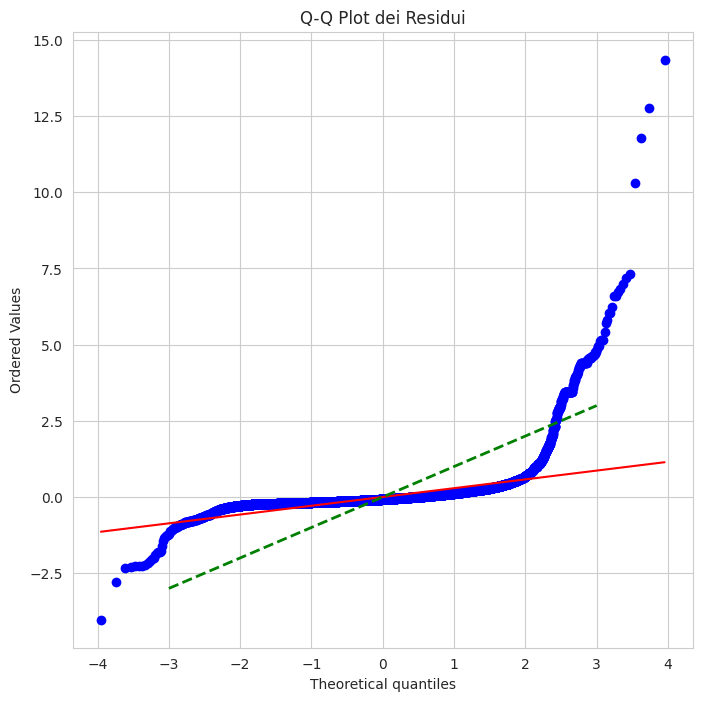

In [ ]:
import scipy.stats as stats

# Q-Q Plot
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot dei Residui')

# Aggiungi una linea di riferimento a 45°
plt.plot([-3, 3], [-3, 3], color='green', linestyle='--', linewidth=2)

plt.show()

L'asse X rappresenta i quantili teorici di una distribuzione normale standard.

L'asse Y rappresenta i quantili osservati dei residui del tuo modello.

La linea rossa rappresenta la perfetta normalità: se i residui fossero normali, i punti sarebbero allineati su questa linea.

Sembra che i punti si discostino dalla linea retta sia in coda sinistra che destra.
Questo indica che la distribuzione dei residui ha code più pesanti rispetto a una normale, evidenziando l'oramai ovvia presenza di outlier.

In particolare si notano forti outlier positivi.



---



# **4. Clustering**

Dopo aver esplorato e analizzato approfonditamente le caratteristiche generali dei viaggi effettuati dai taxi nella città di New York, emerge spontanea la necessità di approfondire la nostra analisi sotto un'altra prospettiva, ovvero quella geografica e spaziale.

Per comprendere meglio la distribuzione delle corse sul territorio, abbiamo deciso di adottare la tecnica del clustering, particolarmente utile per identificare gruppi o raggruppamenti naturali all’interno di un insieme di dati.

individuare aree specifiche della città che presentano caratteristiche simili in termini di densità e frequenza delle corse. L'obiettivo è duplice: da un lato, capire se esistono zone specifiche con una concentrazione insolitamente alta di viaggi, e dall'altro individuare eventuali aree isolate, distanti dalle più note zone centrali ma comunque molto attive dal punto di vista del traffico taxi.

### 🔬4.1 K-means

Tra i vari algoritmi di clustering, il K-Means emerge per semplicità, efficienza computazionale e interpretabilità dei risultati ottenuti.
L’algoritmo K-Means funziona assegnando iterativamente ogni osservazione al gruppo (cluster) più vicino sulla base della distanza euclidea rispetto al centroide di ciascun cluster, ridefinendo poi i centroidi in base alle nuove assegnazioni. Questo processo continua fino alla convergenza, cioè finché i centroidi rimangono stabili.
Nel nostro progetto, il K-Means è stato applicato  a quattro atributi con lo scopo di cercare eventuali pattern all'interno del dataset.

Ora implementiamo l’Elbow Method, una tecnica molto usata per determinare il numero ottimale di cluster nel K-Means.

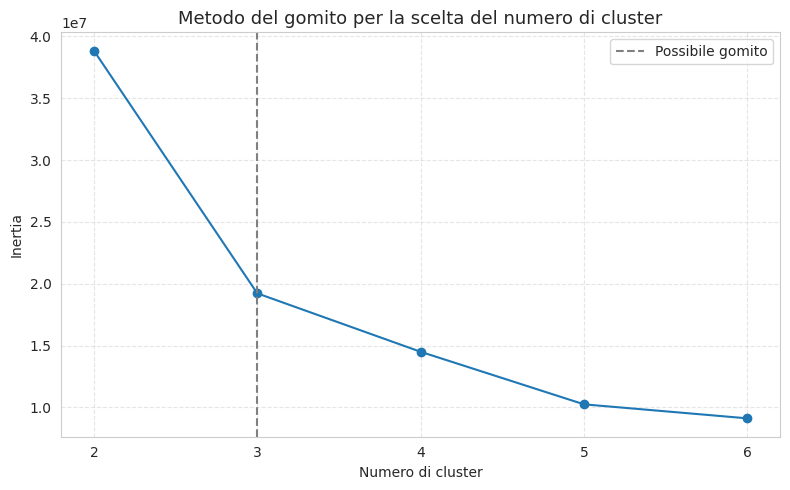

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Dataset numerico per il clustering
X = df_clean[["passenger_count", "trip_distance", "time_duration", "fare_amount"]]

K = [2, 3, 4, 5, 6]   #scegliamo il numero di possibili cluster
inertia = []     #lista vuota dove inserisce i valori di inerzia con il ciclo for

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.axvline(x=3, linestyle='--', color='gray', label='Possibile gomito')  # opzionale
plt.xlabel("Numero di cluster")
plt.ylabel("Inertia")
plt.title("Metodo del gomito per la scelta del numero di cluster", fontsize=13)
plt.xticks(K)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


L'asse x rappresenta il numero di cluster testati
Sull'asse y troviamo il valore dell'inertia, ovvero la somma delle distanze quadratiche di ogni punto dal centro del proprio cluster. Un valore inferiore indica cluster più compatti.
In questo caso, tra 3 e 4 cluster si nota un calo molto marcato dell'inertia.
Da 4 cluster in poi il calo è sensibilmente meno accentuato e tende a stabilizzarsi.
Pertanto, il numero ottimale di cluster sembra essere proprio 4, poiché è in questo punto che ottieni il migliore equilibrio tra complessità del modello e compattezza dei cluster.

In [ ]:
# Scegliamo K = 3 e sviluppiamo i cluster

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

In [ ]:
#vediamo quanti elementi contengono i cluster

summary = pd.Series(labels).value_counts().sort_index()
print(summary)

0    78686
1       91
2    11023
Name: count, dtype: int64


Il Cluster 0 è sproporzionatamente grande, contiene la maggior parte dei dati.
Potrebbe includere una vasta gamma di casi poco differenziati tra loro, oppure potrebbe voler dire che il metodo KMeans non riesce a separare bene i dati.

I cluster 1 e 2 sono molto piccoli, potrebbero essere outlier o un caso di overclustering (K troppo alto)

Il cluster 3 ha una dimensione ragionevole, probabilmente si tratta dell'unico vero sottogruppo nei dati.

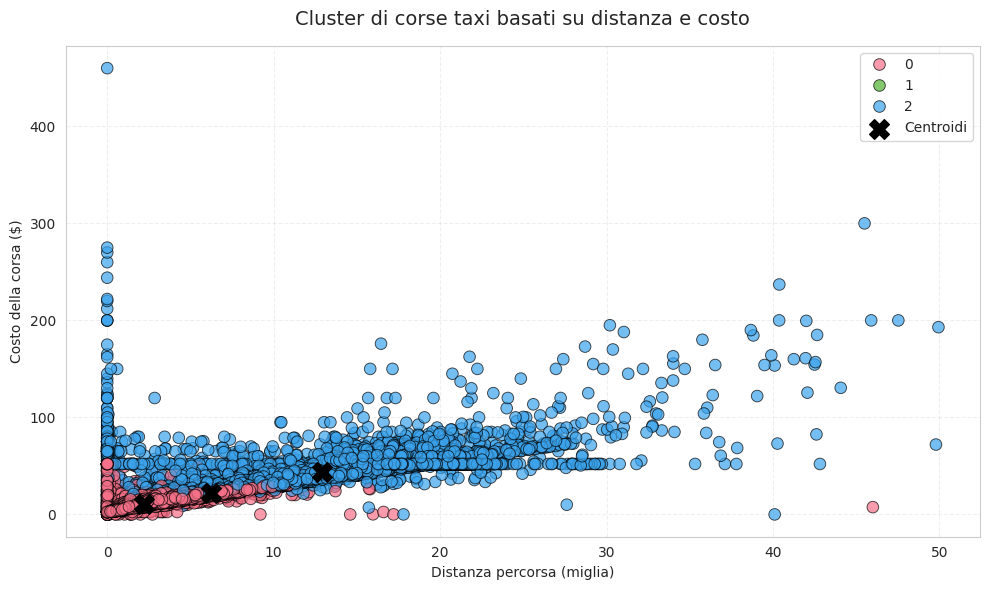

In [ ]:
# scatterplot con cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X["trip_distance"],
    y=X["fare_amount"],
    hue=labels,
    palette=sns.color_palette("husl", n_colors=len(np.unique(labels))),
    alpha=0.7,
    s=70,
    edgecolor='black'
)

# aggiungiamo i centroidi
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, X.columns.get_loc("trip_distance")],
    centroids[:, X.columns.get_loc("fare_amount")],
    s=200,
    c='black',
    marker='X',
    label='Centroidi'
)

# titolo e assi
plt.title("Cluster di corse taxi basati su distanza e costo", fontsize=14, pad=15)
plt.xlabel("Distanza percorsa (miglia)")
plt.ylabel("Costo della corsa ($)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


🔴 Cluster 0:
Corse molto brevi ed economiche, generalmente con trip_distance vicino a 0.
Probabile che includa corse minime o quasi nulle

🟡 Cluster 1:
Pochissimi punti, vicino a coordinate alte di costo.
Probabile gruppo di outlier (corse molto costose).

🟢 Cluster 2:
Piccolo gruppo intermedio, forse corse brevi con prezzi anomali.
Da approfondire: potrebbe contenere anomalie o errori nei dati.

🔵 Cluster 3:
Il gruppo più grande, si estende molto in larghezza.
Probabilmente rappresenta la maggior parte delle corse comuni, con distanze tra 1 e 25 miglia e prezzi da $10 a $70 circa.
Il fatto che inglobi quasi tutto può indicare che K-Means non ha separato perfettamente i gruppi.

✖️ Centroidi:
Ogni "X" nera è il centro medio di un gruppo: la posizione media in termini di distanza e costo.
Più è lontano un punto dal centroide del suo cluster, più potrebbe essere un punto anomalo o marginale.

Rappresentiamo ora su un boxplot la distribuzione del costo delle corse  per ciascun cluster ottenuto.

<ipython-input-101-18a51ec66fa5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=X["fare_amount"], palette="Set2")


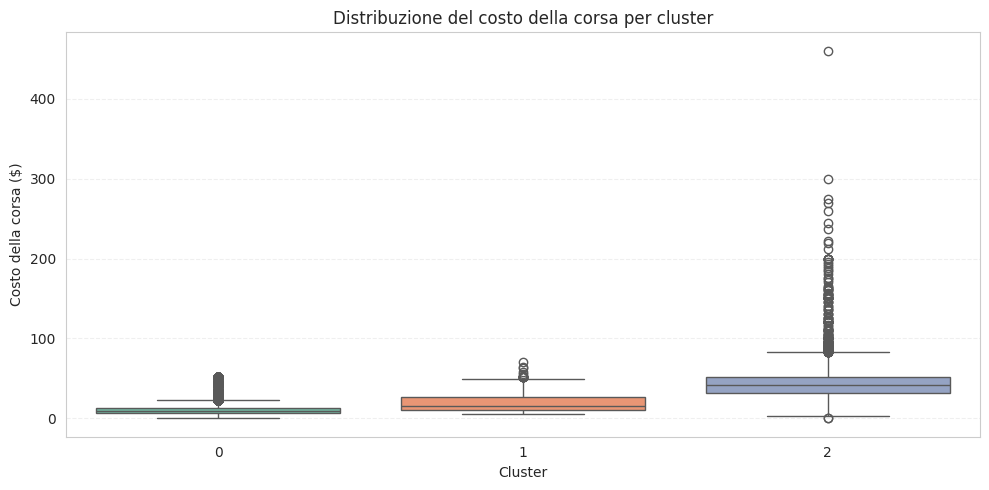

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=labels, y=X["fare_amount"], palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Costo della corsa ($)")
plt.title("Distribuzione del costo della corsa per cluster")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

I cluster 0 e 1 presentano un costo medio piuttosto basso e una distribuzione contenuta, con pochi valori anomali. È probabile che rappresentino corse brevi o standard.

Il cluster 2 mostra una variabilità maggiore, includendo corse con tariffe più elevate rispetto ai precedenti, pur mantenendo una distribuzione relativamente compatta.

plottiamo anche la distribuzione della durata delle corse

<ipython-input-102-2382f4d703c1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


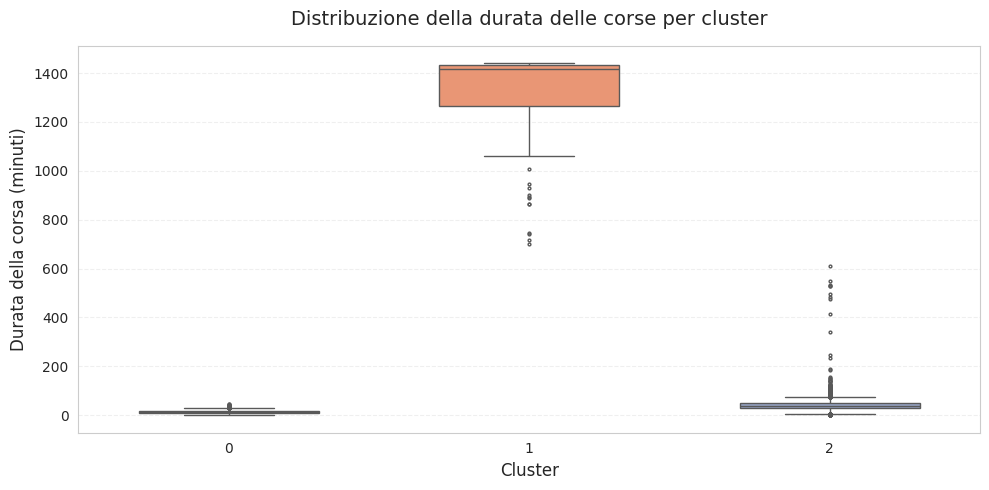

In [ ]:
plt.figure(figsize=(10, 5))

# Boxplot: durata per cluster
sns.boxplot(
    x=labels,
    y=X["time_duration"],
    palette="Set2",
    width=0.6,
    fliersize=2  # dimensione dei punti outlier
)

# Etichette e titolo corretti
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Durata della corsa (minuti)", fontsize=12)
plt.title("Distribuzione della durata delle corse per cluster", fontsize=14, pad=15)

# Griglia
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


I cluster 0 e 2 rappresentano più o meno corse brevi della stessa durata, ma il cluster 2 racchiude anche alcuni outliers, a differenza del cluster 1 che racchiude corse con durata alta.



---



### 🗺️ 4.2 Analisi geospaziale

Riteniamo opportuno rappresentare alcune variabili in un contesto geospaziale, in modo da poter mostrare quali siano le zone di interesse per le compagnie di taxi:
iniziamo ad ottenere i dati dalla tabella taxi_geom, che contiene i seguenti attributi


* 🏘️   `zone_id`: l’ID numerico della zona
*  🗂️ `zone_name`: il nome della zona
*   🏢`borough`: il distretto
*   📐`zone_geom`: è una colonna di tipo GEOGRAPHY (quindi contiene poligoni)


In [ ]:
# otteniamo da bigquery le colonne zone_id, zone_name, borough e zone_geom, convertendo l'ultima in wkt perchè non poteva raggruppare
query_zones = """
SELECT
  zone_id,
  zone_name,
  borough,
  ST_AsText(zone_geom) AS zone_geom -- Converto in WKT (stringa leggibile)
FROM
  `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`
"""

df2 = client.query(query_zones).to_dataframe()

In [ ]:
#creo il df pickup_counts, che raggruppa i dati per colonna pickup_location_id, rumovendo le altre colonne

pickup_counts = df.groupby('pickup_location_id').size().reset_index(name='num_pickups')


#mergiamo i due dataframe, df2 e pickup_counts tramite un left join

df_merged = df2.merge(
    pickup_counts,
    left_on='zone_id',
    right_on='pickup_location_id',
    how='left')

In [ ]:
from shapely import wkt   #libreria Python che gestisce geometrie
import geopandas as gpd

#creiamo la colonna geometry che riconverte la colonna zone_geom in oggetti geometrici
df_merged['geometry'] = df2['zone_geom'].apply(wkt.loads)

#trasformazione in geodataframe tramite geopandas
gdf = gpd.GeoDataFrame(df_merged, geometry='geometry')

In [ ]:
import folium
import numpy as np
from folium.plugins import HeatMap

# creiamo la mappa centrata su NY
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepara i dati per la heatmap
heat_data = [
    [geom.centroid.y, geom.centroid.x, pickups if not np.isnan(pickups) else 0]
    for geom, pickups in zip(gdf.geometry, gdf['num_pickups'])
]

# Aggiunge la heatmap
HeatMap(heat_data, radius=15).add_to(m)

# Mostra la mappa
m

Questa prima heatmap mostra i luoghi in cui la variabile `pickup_location_id` si verifica più spesso.
Le zone dove le corse iniziano sono nell'upper east side, in generale a Manhattan: questo grafico potrebbe tornare utile per fornire informazioni ai tassisti sulle zone da frequentare quando cercano passeggeri, per massimizzare il numero di corse giornaliere.

Ne approfittiamo per installare le librerie libpysal ed esda, che fanno parte di un insieme di librerie Python orientate all'analisi spaziale e geografica.

In [ ]:
pip install libpysal esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 10.9 MB/s eta 0:00:00


disegnamo ora una mappa per analizzare il costo medio

In [ ]:
# calcoliamo il costo medio
average_fare_amounts = df.groupby('pickup_location_id')["fare_amount"].mean().reset_index()
average_fare_amounts.columns = ["pickup_location_id", "average_fare_amount"]



#mergiamo i due dataframe, df2 e average_fare_amount tramite un left join

df_costo_merged = df2.merge(
    average_fare_amounts,
    left_on='zone_id',
    right_on='pickup_location_id',
    how='left'
)


#creiamo la colonna geometry che riconverte la colonna zone_geom in oggetti geometrici
df_costo_merged['geometry'] = df2['zone_geom'].apply(wkt.loads)

#trasformazione in geodataframe tramite geopandas
gdf_costo = gpd.GeoDataFrame(df_costo_merged, geometry='geometry')

# creiamo la mappa centrata su NY
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepara i dati per la heatmap
heat_data = [
    [geom.centroid.y, geom.centroid.x, pickups if not np.isnan(pickups) else 0]
    for geom, pickups in zip(gdf_costo.geometry, gdf_costo['average_fare_amount'])
]

# Aggiunge la heatmap
HeatMap(heat_data, radius=15).add_to(m)

# Mostra la mappa
m

Possiamo notare che, oltre alle zone già citate del centro di New York, il costo medio è decisamente più alto in prossimità dell'aereoporto di Newark Liberty, nel new Jersey

Dopo aver mostrato tre heatmap differenti vogliamo capire se la variabile `average_fare_amount` mostra un pattern spaziale:
le aree vicine hanno valori simili?
oppure i valori sono distribuiti casualmente?
Per rispondere a queste domande, eseguiremo un'analisi di autocorrelazione spaziale sui dati contenuti in un GeoDataFrame (gdf_costo), utilizzando le statistiche di Moran's I e Geary's C, due metriche classiche dell’analisi esplorativa dei dati spaziali (ESDA).

In [ ]:
# importiamo le librerie
from esda import Moran, Geary
import libpysal

# riempiamo i valori mancanti con 0
gdf_costo['average_fare_amount'] = gdf_costo['average_fare_amount'].fillna(0)

# creiamo la matrice di contiguità (Queen)
w = libpysal.weights.Queen.from_dataframe(gdf_costo)
w.transform = 'r'  # normalizzazione row-standardized

# calcolo Moran's I
moran_costo = Moran(gdf_costo['average_fare_amount'], w)
print(f"Moran's I: {moran_costo.I:.4f}, p-value: {moran_costo.p_sim:.4f}")

# calcolo Geary's C
geary_costo = Geary(gdf_costo['average_fare_amount'], w)
print(f"Geary's C: {geary_costo.C:.4f}, p-value: {geary_costo.p_sim:.4f}")

<ipython-input-81-b43df7ff7163>:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf_costo)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 192, ' is an island (no neighbors)')
('WARNING: ', 193, ' is an island (no neighbors)')
('WARNING: ', 194, ' is an island (no neighbors)')
('WARNING: ', 222, ' is an island (no neighbors)')
Moran's I: 0.0710, p-value: 0.0440
Geary's C: 0.8384, p-value: 0.0140


/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 6 islands with ids: 0, 6, 192, 193, 194, 222.
  W.__init__(self, neighbors, ids=ids, **kw)


Abbiamo costruito una matrice di contiguità spaziale "Queen", in cui due aree (es. quartieri o celle) sono considerate vicine se condividono almeno un lato o un vertice, dopodichè abbiamo normaizzato i pesi in modo che sommino a 1 per ogni riga.
Una breve introduzione sugli indici calcolati:

Moran’s I misura l’autocorrelazione spaziale globale:
Se > 0, indica cluster positivi: aree vicine tendono ad avere tariffe simili (es. aree costose vicine ad altre costose).
Se < 0, indica disperisione: aree vicine tendono ad avere valori opposti.
Se ≈ 0, non c'è autocorrelazione spaziale.

Geary’s C è un'altra misura di autocorrelazione spaziale, più sensibile alle differenze locali:
Se < 1, indica autocorrelazione positiva (valori simili raggruppati).
Se > 1, indica autocorrelazione negativa (valori dissimili vicini).
Se ≈ 1, nessuna autocorrelazione.

L’analisi dell’autocorrelazione spaziale condotta sulle tariffe medie mostra la presenza di un pattern non casuale.
L’indice di Moran suggerisce una leggera autocorrelazione positiva, ovvero che le zone geograficamente contigue tendono ad avere tariffe simili.
Questo è confermato anche dall’indice di Geary, il cui valore inferiore a 1 indica una tendenza alla similarità tra aree adiacenti.
I risultati sono statisticamente significativi, suggerendo l’esistenza di cluster spaziali di tariffe che meritano ulteriore esplorazione e visualizzazione.


Infine, ridisegnamo la heatmap per analizzare quali sono i luoghi che offrono mance più alte per i tassisti

In [ ]:
average_tip_amounts = df.groupby('pickup_location_id')["tip_amount"].mean().reset_index()
average_tip_amounts.columns = ["pickup_location_id", "average_tip_amount"]
#mergiamo i due dataframe, df2 e average_fare_amount tramite un left join

df_mance_merged = df2.merge(
    average_tip_amounts,
    left_on='zone_id',
    right_on='pickup_location_id',
    how='left'
)


#creiamo la colonna geometry che riconverte la colonna zone_geom in oggetti geometrici
df_mance_merged['geometry'] = df2['zone_geom'].apply(wkt.loads)

#trasformazione in geodataframe tramite geopandas
gdf_mance = gpd.GeoDataFrame(df_mance_merged, geometry='geometry')

# creiamo la mappa centrata su NY
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepara i dati per la heatmap
heat_data = [
    [geom.centroid.y, geom.centroid.x, pickups if not np.isnan(pickups) else 0]
    for geom, pickups in zip(gdf_mance.geometry, gdf_mance['average_tip_amount'])
]

# Aggiunge la heatmap
HeatMap(heat_data, radius=15).add_to(m)

# Mostra la mappa
m

Avendo unito il dataframe con la colonna `pickup_location_id` possiamo supporre che i turisti concedano mance più alte, in quanto la zona dell'aereoporto continua ad essere evidenziata nella heatmap

# **5. Conclusioni**

 I modelli di ML allenati sembrano essere aver raggiunto un risultato soddisfacente nella predizione del costo delle corse.

Abbiamo confrontato un modello Random Forest e una Regressione Lineare:
 Il primo sembra avete una performance migliore numericamente, in quanto riesce a spiegare circa l'80% dei dati.

Invece, nonostante il modello di regressione lineare abbia una performance numerica leggermente inferiore, il tempo
di addestramento è decisamente più basso. Nel caso in cui lavorassimo con un dataset di grandi dimensioni preferiremmo quest'ultimo.
